In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import re
import sys
import torch
from tqdm import tqdm

personal_ID = 1036
sys.path.append(
    f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/Code/Marta"
)
from deepemotions.FINAL_deepcluster_NOTSEQ_GPU import DeepCMeams
from deepemotions.preprocess import preprocessing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
'''def select_best_threshold_pickle(subject_data_dir, verbose=True):
    """
    Select best Deep C-Means pickle for one subject.
    """

    # --------------------------------------------------
    # 1) FIND CANDIDATE PICKLES
    # --------------------------------------------------
    pattern = re.compile(r"marta_test_results_thr.*\.pkl$")
    # pattern = re.compile(r".*test_results_thr.*\.pkl$")
    files = [
        os.path.join(subject_data_dir, f)
        for f in os.listdir(subject_data_dir)
        if pattern.match(f)
    ]

    if len(files) == 0:
        raise FileNotFoundError("No marta_test_results_thr*.pkl files found")
        # raise FileNotFoundError("No test_results_thr*.pkl files found")

    rows = []

    # --------------------------------------------------
    # 2) LOAD METRICS
    # --------------------------------------------------
    for path in files:
        with open(path, "rb") as f:
            data = pickle.load(f)

        rows.append({
            "path": path,
            "filename": os.path.basename(path),
            "threshold": data.get("threshold"),
            "mean_acc": data.get("mean_acc"),
            "mean_acc_stress": data.get("mean_acc_stress"),
            "mean_sil": data.get("mean_sil"),
            "std_sil": data.get("std_sil"),
        })

    df = pd.DataFrame(rows)

    if verbose:
        print("\n[MODEL SELECTION] Available models:")
        display(df.sort_values("threshold"))

    # --------------------------------------------------
    # 3) FILTER BY SILHOUETTE (SUBJECT-SPECIFIC). ############# needs to be fixed ##########
    # --------------------------------------------------
    sil_cut = df["mean_sil"].median()
    df_filt = df[df["mean_sil"] >= sil_cut].copy()

    if df_filt.empty:
        raise RuntimeError("All models discarded by silhouette filter")

    # --------------------------------------------------
    # 4) SELECT BEST MODEL
    # --------------------------------------------------
    df_filt = df_filt.sort_values(
        by=["mean_acc_stress", "mean_acc", "mean_sil"],
        ascending=False
    )

    best = df_filt.iloc[0]

    if verbose:
        print("\n[MODEL SELECTION] Selected model:")
        display(best.to_frame().T)

    return best["path"], best, df

'''
def select_best_threshold_pickle(subject_data_dir, verbose=True):
    """
    Select best Deep C-Means pickle for one subject.
    Uses silhouette as a subject-specific quality filter, then ranks models
    primarily by the NEW stress accuracy metrics (if available).
    """

    # --------------------------------------------------
    # 1) FIND CANDIDATE PICKLES
    # --------------------------------------------------
    # pattern = re.compile(r"marta_test_results_thr.*\.pkl$")
    pattern = re.compile(r"test_results_thr.*\.pkl$")
    files = [
        os.path.join(subject_data_dir, f)
        for f in os.listdir(subject_data_dir)
        if pattern.match(f)
    ]

    if len(files) == 0:
        # raise FileNotFoundError("No marta_test_results_thr*.pkl files found")
        raise FileNotFoundError("No test_results_thr*.pkl files found")

    rows = []

    # --- inside select_best_threshold_pickle ---

    # --------------------------------------------------
    # 2) LOAD METRICS
    # --------------------------------------------------
    for path in files:
        with open(path, "rb") as f:
            data = pickle.load(f)

        rows.append({
            "path": path,
            "filename": os.path.basename(path),
            "threshold": data.get("threshold"),

            # metrics that DO exist in your pickles
            "mean_acc": data.get("mean_acc"),
            "mean_acc_stress": data.get("mean_acc_stress"),
            "mean_sil": data.get("mean_sil"),
            "mean_f1_stress": data.get("mean_f1_stress"),
            "mean_f1_calm": data.get("mean_f1_calm"),

            # optional training metrics (sometimes useful for debugging)
            "mean_acc_train": data.get("mean_acc_train"),
            "mean_acc_stress_train": data.get("mean_acc_stress_train"),

            # keep hyperparams for inspection / later use
            "hyperparameters": data.get("hyperparameters"),

        })

    df = pd.DataFrame(rows)

    # ---- REMOVE the old fallback block, because new_mean_* are not in your pickles ----
    # df["new_mean_acc_stress"] = ...
    # df["new_mean_acc"] = ...

    if verbose:
        print("\n[MODEL SELECTION] Available models:")
        display(df.sort_values("threshold"))

    # --------------------------------------------------
    # 3) FILTER BY SILHOUETTE (SUBJECT-SPECIFIC)
    # --------------------------------------------------
    sil_cut = df["mean_sil"].median()
    df_filt = df[df["mean_sil"] >= sil_cut].copy()

    if df_filt.empty:
        raise RuntimeError("All models discarded by silhouette filter")

    # --------------------------------------------------
    # 4) SELECT BEST MODEL (silhouette only)
    # --------------------------------------------------
    # df_filt = df_filt.sort_values(
    #    by=[
    #       "mean_sil",
    #        "mean_acc_stress",
    #        "mean_acc"
    #    ],
    #    ascending=[False, False, False],
    #)

    # best = df_filt.iloc[0]

    # return best["path"], best, df

    # --------------------------------------------------
    # 4) SELECT BEST MODEL (rank by  stress accuracy)
    # --------------------------------------------------
    df_filt = df_filt.sort_values(
        by=[
            "mean_acc_stress",      # primary
            "mean_acc",             # secondary
            "mean_sil"             # cluster quality
        ],
        ascending=[False, False, False],
    )

    best = df_filt.iloc[0]

    if verbose:
        print("\n[MODEL SELECTION] Selected model:")
        display(best.to_frame().T)

    return best["path"], best, df



Participant ID
[133 118 112 134 101 110 121 132 111 130 105 114 151 123 139 129 108 117
 104 142 126 122 136 143 152 157 109 153 158 160 148 156 159 164 154 103
 146 138 161 162 163 165 168 172 170 231 242 226 174 274 215 216 265 269
 282 256 255 286 201 271 280 277 220 210 237 228 188 227 184 223 182 266
 191 305 339 368 307 304 290 253 388 315 303 318 308 411 412 399 410 349
 366 329 415 313 373 355 390 370 436 306 352 414 457 389 482 287 486 322
 438 451 429 483 488 487 441 489]
number of participants: 116

In [3]:
diary_df = pd.read_pickle('/home/s232713/data/final_merged_data.pkl')
subj_names = diary_df['participant ID'].unique().astype(str).tolist()
# subj_names = ['103']
# subj_names = diary_df[diary_df['Participant ID'] == 253]['Participant ID'].unique().astype(str).tolist()
print(subj_names)
print('number of subjects:', len(subj_names))

['133', '118', '112', '134', '101', '110', '121', '132', '111', '130', '105', '114', '151', '123', '139', '129', '108', '117', '104', '142', '126', '122', '136', '143', '152', '157', '109', '153', '158', '160', '148', '156', '159', '164', '154', '103', '146', '138', '161', '162', '163', '165', '168', '172', '170', '231', '242', '226', '174', '274', '215', '216', '265', '269', '282', '256', '255', '286', '201', '271', '280', '277', '220', '210', '237', '228', '188', '227', '184', '223', '182', '266', '191', '305', '339', '368', '307', '304', '290', '253', '388', '315', '303', '318', '308', '411', '412', '399', '410', '349', '366', '329', '415', '313', '373', '355', '390', '370', '436', '306', '352', '414', '457', '389', '482', '287', '486', '322', '438', '451', '429', '483', '488', '487', '441', '489']
number of subjects: 116


In [4]:
results = {}

for subj_name in subj_names:
    print(f"\n==============================")
    print(f"[SUBJECT] {subj_name}")
    print(f"==============================")

    BASE_PATH = (
        f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
        f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
    )

    try:
        best_pkl_path, best_row, selection_df = select_best_threshold_pickle(
            BASE_PATH,
            verbose=True
        )
    except Exception as e:
        print(f"[SKIP] Subject {subj_name}: {e}")
        continue

    with open(best_pkl_path, "rb") as f:
        data = pickle.load(f)

    

    fold0 = data["fold_results"][0]

    # store for later use / debugging
    results[subj_name] = {
        "best_pkl_path": best_pkl_path,
        "selection_row": best_row,
        "selection_table": selection_df,
        "fold0": fold0,
    }

    print(f"[OK] Selected model: {os.path.basename(best_pkl_path)}")



[SUBJECT] 133

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.928590,0.333594,0.89402,0.500293,0.961548,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.886425826366773e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.239275,0.879973,0.81679,0.267418,0.090192,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0003034618291513..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.92859,0.333594,0.89402,0.500293,0.961548,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.886425826366773e..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 118

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr3_0.pkl,3.0,0.504464,0.500000,0.760522,0.053094,0.494755,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0007846774527215..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_0.pkl,5.0,0.304301,0.835286,0.796863,0.314854,0.153230,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.409814538623341e..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.528385,0.406335,0.742144,0.223659,0.467648,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.085557643858019e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_0.pkl,5.0,0.304301,0.835286,0.796863,0.314854,0.15323,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.409814538623341e..."


[OK] Selected model: test_results_thr5_0.pkl

[SUBJECT] 112

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.867738,0.103717,0.907625,0.135580,0.928391,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.597538781449062e..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.232232,0.948181,0.922427,0.330672,0.099845,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0022725455698074..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.302189,0.069578,0.921629,0.130102,0.417434,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0017801010130637..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.232232,0.948181,0.922427,0.330672,0.099845,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0022725455698074..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 134

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.226133,1.000000,0.944690,0.301081,0.133181,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002587592077824..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.326233,1.000000,0.948755,0.441834,0.150239,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002952069851007..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.787241,0.954811,0.943558,0.877754,0.180379,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001769768946091..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.326233,1.0,0.948755,0.441834,0.150239,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002952069851007..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 101

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.846700,0.100000,0.622966,0.012496,0.868985,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0008611389561359..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.728908,0.063314,0.867914,0.110744,0.840077,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0014933362999217..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.628954,0.046079,0.876552,0.083450,0.767394,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.6771978648208144..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.728908,0.063314,0.867914,0.110744,0.840077,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0014933362999217..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 110

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.193519,0.078263,0.899736,0.145164,0.236695,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 7.671656900059336e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.193519,0.078263,0.899736,0.145164,0.236695,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 7.671656900059336e..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 121

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.319515,1.000000,0.732310,0.335643,0.299209,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0007153454004567..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.604534,0.849554,0.729028,0.729577,0.262900,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002942749168250..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.634623,0.850574,0.719976,0.753630,0.292638,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 4.1657485010519e-0..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.319515,1.0,0.73231,0.335643,0.299209,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0007153454004567..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 132

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.736793,0.499665,0.983387,0.166625,0.843717,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0011803699879964..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.352653,0.699937,0.986119,0.183028,0.448855,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0022561852832340..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.473674,0.321434,0.983563,0.473688,0.473660,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0024959748597654..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.352653,0.699937,0.986119,0.183028,0.448855,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0022561852832340..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 111

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.419372,0.697321,0.667161,0.140928,0.419876,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0022700458451203..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.376777,0.700000,0.903685,0.191037,0.332332,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 4.879679524676002e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.469395,0.800000,0.621087,0.483108,0.193314,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0017455957444774..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.376777,0.7,0.903685,0.191037,0.332332,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 4.879679524676002e..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 130

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.428472,0.999329,0.626242,0.333156,0.499948,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002640055561799..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.534986,0.661026,0.631888,0.402503,0.539721,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0003558047350164..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.676072,0.764424,0.635757,0.672161,0.554243,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.747087165016572e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.676072,0.764424,0.635757,0.672161,0.554243,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.747087165016572e..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 105
[SKIP] Subject 105: No test_results_thr*.pkl files found

[SUBJECT] 114

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_0.pkl,6.0,0.938121,0.000000,0.926369,0.000000,0.968073,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.2269495607623137..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.370777,0.956909,0.873847,0.509108,0.105866,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001432816990625..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.682773,1.000000,0.911373,0.805093,0.148196,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.236504692201121e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.682773,1.0,0.911373,0.805093,0.148196,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.236504692201121e..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 151
[SKIP] Subject 151: No test_results_thr*.pkl files found

[SUBJECT] 123
[SKIP] Subject 123: No test_results_thr*.pkl files found

[SUBJECT] 139
[SKIP] Subject 139: No test_results_thr*.pkl files found

[SUBJECT] 129

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.836487,0.431252,0.861110,0.369467,0.906063,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0004019745350488..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.669681,0.172548,0.863656,0.224974,0.790112,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0027338391407015..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.205931,0.159207,0.834215,0.274657,0.122783,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001677128762264..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.836487,0.431252,0.86111,0.369467,0.906063,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0004019745350488..."


[OK] Selected model: test_results_thr5_5.pkl

[SUBJECT] 108

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_0.pkl,5.0,0.395514,0.897079,0.749164,0.484250,0.082757,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0010291042292958..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_0.pkl,8.0,0.494318,0.599368,0.901498,0.385408,0.275787,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002965228856820..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.685169,0.683347,0.518377,0.784768,0.410779,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002373317471417..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_0.pkl,5.0,0.395514,0.897079,0.749164,0.48425,0.082757,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0010291042292958..."


[OK] Selected model: test_results_thr5_0.pkl

[SUBJECT] 117
[SKIP] Subject 117: No test_results_thr*.pkl files found

[SUBJECT] 104
[SKIP] Subject 104: No test_results_thr*.pkl files found

[SUBJECT] 142

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.914433,0.000000,0.901433,0.000000,0.955304,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002567852048243..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.265408,0.978265,0.770669,0.371769,0.110454,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004025808038892..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.455589,0.400000,0.690965,0.335465,0.260945,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0011976675674727..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.265408,0.978265,0.770669,0.371769,0.110454,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004025808038892..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 126

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.740064,0.200000,0.919670,0.036400,0.757918,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0005091397514332..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.619933,0.200000,0.897388,0.092292,0.658786,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001130723366352..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.416315,0.219466,0.669011,0.199667,0.439336,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0019483429184792..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.740064,0.2,0.91967,0.0364,0.757918,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0005091397514332..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 122

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.278955,0.800000,0.795469,0.186020,0.185930,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0013167022044066..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.420950,0.800000,0.693627,0.430682,0.154823,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001276183798769..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.530512,0.555674,0.422374,0.506870,0.215140,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0014536201829028..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.42095,0.8,0.693627,0.430682,0.154823,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001276183798769..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 136
[SKIP] Subject 136: No test_results_thr*.pkl files found

[SUBJECT] 143

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.685488,0.320265,0.545733,0.408092,0.776943,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 4.512507831842101e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.309631,0.156300,0.674470,0.260828,0.346824,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0005627158779531..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.182112,0.100328,0.733162,0.182360,0.181863,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001371123204279..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.309631,0.1563,0.67447,0.260828,0.346824,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0005627158779531..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 152

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.510657,1.000000,0.612473,0.285517,0.586229,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001987011474618..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.596897,0.760577,0.546520,0.559698,0.621252,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0023421007617883..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.510657,1.0,0.612473,0.285517,0.586229,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001987011474618..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 157

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.699537,0.899331,0.535127,0.504228,0.776657,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.246203876880441e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.575766,0.787606,0.605806,0.544720,0.598636,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002271989861864..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.600642,0.668021,0.610400,0.567533,0.544721,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0006718868942938..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.575766,0.787606,0.605806,0.54472,0.598636,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002271989861864..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 109

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.505813,0.500000,0.894342,0.033759,0.502545,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 8.531538496783213e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.533860,0.813073,0.201692,0.197226,0.655689,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0024432774903593..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.263075,0.800000,0.804484,0.150234,0.191221,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0022334595568596..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.263075,0.8,0.804484,0.150234,0.191221,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0022334595568596..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 153

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.210552,0.900000,0.935738,0.169509,0.166035,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 4.103613595046545e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.323783,0.975888,0.944667,0.464056,0.084053,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0019303053815329..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.323783,0.975888,0.944667,0.464056,0.084053,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0019303053815329..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 158

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.545365,0.500000,0.905526,0.121242,0.558220,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0002858431560709..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.324979,0.228578,0.817811,0.325010,0.324948,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0007368864669308..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.545365,0.5,0.905526,0.121242,0.55822,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0002858431560709..."


[OK] Selected model: test_results_thr9_0.pkl

[SUBJECT] 160

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.647330,0.319308,0.723859,0.401239,0.718187,0.960848,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001000296801774..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.532848,0.433987,0.709990,0.362616,0.525669,0.960848,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0012246571757202..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.414377,0.150329,0.746598,0.253359,0.515851,1.000000,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.6092537567747835..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.64733,0.319308,0.723859,0.401239,0.718187,0.960848,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001000296801774..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 148

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.062107,1.000000,0.747396,0.108636,0.010331,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0014707783721147..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.121016,1.000000,0.767700,0.206352,0.014964,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0027662237569823..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.609363,0.296864,0.708120,0.173080,0.639896,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0008774220795729..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.121016,1.0,0.7677,0.206352,0.014964,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0027662237569823..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 156

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.774080,0.200000,0.81470,0.014835,0.782825,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 8.937759355487612e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.652052,0.697961,0.81436,0.656131,0.062058,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0009011924553561..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.77408,0.2,0.8147,0.014835,0.782825,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 8.937759355487612e..."


[OK] Selected model: test_results_thr9_0.pkl

[SUBJECT] 159
[SKIP] Subject 159: No test_results_thr*.pkl files found

[SUBJECT] 164
[SKIP] Subject 164: No test_results_thr*.pkl files found

[SUBJECT] 154
[SKIP] Subject 154: No test_results_thr*.pkl files found

[SUBJECT] 103

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.333845,0.900000,0.805062,0.407149,0.082878,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.422804096573398e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.533927,0.895792,0.790015,0.632485,0.068796,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0012820585742640..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.908711,1.000000,0.747614,0.952172,0.000000,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002951303698796..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.333845,0.9,0.805062,0.407149,0.082878,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.422804096573398e..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 146

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.500009,0.5,0.873754,0.033361,0.491225,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0016084778787294..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.262137,0.8,0.909118,0.150078,0.189103,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.404264585660361e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.262137,0.8,0.909118,0.150078,0.189103,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.404264585660361e..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 138

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.745403,0.954074,0.453709,0.722201,0.761723,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0003217811092967..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.861204,0.799151,0.432650,0.880549,0.833169,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0017763572070318..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.745403,0.954074,0.453709,0.722201,0.761723,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0003217811092967..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 161
[SKIP] Subject 161: No test_results_thr*.pkl files found

[SUBJECT] 162

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.888860,0.000000,0.819069,0.000000,0.941160,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 7.748849118536631e..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.500019,0.500000,0.862696,0.181820,0.437511,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0010743780815194..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.289975,0.233168,0.700550,0.377777,0.172718,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 3.758507816966444e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.500019,0.5,0.862696,0.18182,0.437511,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0010743780815194..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 163

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_0.pkl,6.0,0.408736,0.6,0.840248,0.050015,0.391128,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0001170490690423..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.391233,1.0,0.921041,0.562427,0.000000,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0001549106962523..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.826023,1.0,0.931680,0.904724,0.000000,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0012375216615367..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.826023,1.0,0.93168,0.904724,0.0,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0012375216615367..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 165
[SKIP] Subject 165: No test_results_thr*.pkl files found

[SUBJECT] 168

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.844923,0.249832,0.801216,0.331521,0.912287,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0003170988142192..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.721000,0.224020,0.693725,0.252462,0.790472,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0008167936418802..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.500006,0.500000,0.766985,0.257220,0.395302,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0020851468791634..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.500006,0.5,0.766985,0.25722,0.395302,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0020851468791634..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 172

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.552943,0.415763,0.755596,0.130412,0.562757,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0022693401947479..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.396215,0.666588,0.134618,0.327347,0.362902,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0006245624980621..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.501388,0.298531,0.449313,0.240925,0.523783,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0009868587003044..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.552943,0.415763,0.755596,0.130412,0.562757,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0022693401947479..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 170

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.769941,0.20000,0.720065,0.019147,0.781327,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0005346818493957..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.706099,0.32361,0.632108,0.253888,0.803848,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.233116678612281e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.498097,0.68763,0.625305,0.535857,0.349424,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002914692658030..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.706099,0.32361,0.632108,0.253888,0.803848,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.233116678612281e..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 231

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.281625,0.837793,0.343900,0.144577,0.310596,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0003517791895256..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.469133,0.905834,0.423401,0.335437,0.542446,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0027274259245909..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.496604,0.342686,0.562496,0.466452,0.523102,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0003270535362105..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.469133,0.905834,0.423401,0.335437,0.542446,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0027274259245909..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 242

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.566141,0.428419,0.798917,0.037621,0.576288,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002239489388029..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.566141,0.428419,0.798917,0.037621,0.576288,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002239489388029..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 226

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.661120,0.300000,0.675650,0.058745,0.669151,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.501613427684035e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.473776,0.512731,0.483054,0.176733,0.506648,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 3.822919771239616e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.66112,0.3,0.67565,0.058745,0.669151,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.501613427684035e..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 174

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.500003,0.5,0.844186,0.121206,0.462967,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0003216776577739..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.499996,0.5,0.813021,0.236852,0.408154,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 8.435608162592767e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.500003,0.5,0.844186,0.121206,0.462967,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0003216776577739..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 274

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.105429,0.992953,0.786120,0.059444,0.140185,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0019734628205110..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.254014,0.800000,0.748825,0.126022,0.198209,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 7.507186053267488e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.796957,0.864753,0.621646,0.837476,0.246577,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 5.9673503967566e-0..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.105429,0.992953,0.78612,0.059444,0.140185,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0019734628205110..."


[OK] Selected model: test_results_thr7_0.pkl

[SUBJECT] 215

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.055844,0.98424,0.714017,0.076985,0.032134,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0001496946571730..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.533851,0.39788,0.384195,0.185693,0.596196,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001481903226030..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.239975,1.00000,0.833860,0.387064,0.000000,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001225485248683..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.239975,1.0,0.83386,0.387064,0.0,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001225485248683..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 216

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.662525,0.3,0.888248,0.051462,0.665576,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0021733133986289..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.799979,0.1,0.907693,0.022230,0.839985,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002316059409554..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.706232,0.2,0.911484,0.054053,0.732194,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002823554586658..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.706232,0.2,0.911484,0.054053,0.732194,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002823554586658..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 265

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.159729,1.0,0.943859,0.090067,0.219482,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004846111128666..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.159729,1.0,0.943859,0.090067,0.219482,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004846111128666..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 269

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.470330,0.585830,0.501320,0.282335,0.399369,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002723664480329..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.411434,0.142055,0.635077,0.150466,0.484898,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 5.981241411342786e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.604803,0.636921,0.101199,0.699061,0.248275,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0013974187016219..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.47033,0.58583,0.50132,0.282335,0.399369,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002723664480329..."


[OK] Selected model: test_results_thr9_0.pkl

[SUBJECT] 282

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.179543,0.962081,0.584307,0.075762,0.242734,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0001058912785699..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.179543,0.962081,0.584307,0.075762,0.242734,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0001058912785699..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 256

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.635189,0.340040,0.857966,0.113566,0.663340,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0009346332624743..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.622187,0.068662,0.892771,0.123989,0.759147,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 5.9817793079261836..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.697279,0.965503,0.893324,0.818565,0.086877,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 7.33705630804037e-..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.697279,0.965503,0.893324,0.818565,0.086877,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 7.33705630804037e-..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 255
[SKIP] Subject 255: No test_results_thr*.pkl files found

[SUBJECT] 286

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.314935,0.69698,0.723804,0.049984,0.298802,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0004826627369618..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.160840,0.90000,0.904733,0.124405,0.099974,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 5.012901321455212e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.16084,0.9,0.904733,0.124405,0.099974,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 5.012901321455212e..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 201

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.833398,0.0,0.907048,0.0,0.90913,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001197622730143..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.833398,0.0,0.907048,0.0,0.90913,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001197622730143..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 271

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.246169,0.8,0.752494,0.114296,0.192005,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.0013134011316542..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.230709,1.0,0.949602,0.333315,0.090775,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 4.482645947188102e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.576843,1.0,0.953256,0.717902,0.153620,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0022065829926360..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.576843,1.0,0.953256,0.717902,0.15362,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0022065829926360..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 280

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.116236,1.0,0.942847,0.049955,0.173872,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0001277685557629..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.139526,1.0,0.945748,0.097584,0.177742,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 7.63633723884198e-..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.139526,1.0,0.945748,0.097584,0.177742,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 7.63633723884198e-..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 277

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.665849,1.0,0.752203,0.666148,0.665547,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0001405281829731..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.665849,1.0,0.752203,0.666148,0.665547,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0001405281829731..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 220

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr4_5.pkl,4.5,0.177725,1.000000,0.761115,0.089787,0.236537,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0009160492191934..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.220879,1.000000,0.858544,0.292228,0.127562,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0020864375299180..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.479159,0.914703,0.871300,0.585362,0.180725,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002956856608325..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.220879,1.0,0.858544,0.292228,0.127562,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0020864375299180..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 210

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.500056,0.25023,0.979296,0.400295,0.57136,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0003799872161325..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.500056,0.25023,0.979296,0.400295,0.57136,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0003799872161325..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 237

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.500000,0.666555,0.836672,0.235227,0.628587,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0011020233511957..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.576933,0.799960,0.843749,0.421028,0.666687,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0011668736488490..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.499948,0.442713,0.844211,0.322149,0.603509,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0004489835587097..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.576933,0.79996,0.843749,0.421028,0.666687,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0011668736488490..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 228

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_0.pkl,6.0,0.222134,1.000000,0.939603,0.061826,0.335653,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0024048481052049..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.401594,1.000000,0.944512,0.406718,0.396380,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0021806941468112..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.401585,0.833324,0.942394,0.461455,0.326738,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005523383045695..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.401594,1.0,0.944512,0.406718,0.39638,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0021806941468112..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 188
[SKIP] Subject 188: No test_results_thr*.pkl files found

[SUBJECT] 227

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.677531,0.166695,0.891396,0.166662,0.800086,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 8.792152484249485e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.580598,0.833371,0.934462,0.697628,0.315780,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0012387702572357..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.451680,0.210524,0.937286,0.319999,0.540635,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0029540876005714..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.580598,0.833371,0.934462,0.697628,0.31578,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0012387702572357..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 184

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_0.pkl,10.0,0.937476,0.0,0.891704,0.000000,0.967729,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.711770542561875e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.374995,1.0,0.780983,0.375034,0.374955,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0020955111612200..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_0.pkl,10.0,0.937476,0.0,0.891704,0.0,0.967729,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 4.711770542561875e..."


[OK] Selected model: test_results_thr10_0.pkl

[SUBJECT] 223

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.817627,0.108441,0.945178,0.116708,0.898316,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001880282636933..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.792739,0.219870,0.935153,0.290657,0.878621,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 7.158039687068627e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.261986,0.114411,0.944634,0.205330,0.311101,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0021102523404315..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.261986,0.114411,0.944634,0.20533,0.311101,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0021102523404315..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 182

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.551629,0.576216,0.725420,0.513977,0.354285,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0008702075743424..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.433473,0.320067,0.703636,0.476249,0.373585,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0012495803208736..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.551629,0.576216,0.72542,0.513977,0.354285,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0008702075743424..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 266

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_0.pkl,5.0,0.127651,0.998328,0.799208,0.063280,0.179135,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0018674993591412..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.323544,1.000000,0.940058,0.439030,0.148179,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0009882532102389..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.823489,0.964298,0.923899,0.899972,0.250126,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002602188625115..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.323544,1.0,0.940058,0.43903,0.148179,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0009882532102389..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 191

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.220261,1.0,0.783846,0.100844,0.305377,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0014578725273125..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.299930,1.0,0.760603,0.198996,0.378074,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0005853434926071..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.447820,0.7,0.770289,0.364674,0.261889,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002348972302062..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.220261,1.0,0.783846,0.100844,0.305377,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0014578725273125..."


[OK] Selected model: test_results_thr7_0.pkl

[SUBJECT] 305
[SKIP] Subject 305: No test_results_thr*.pkl files found

[SUBJECT] 339

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.348857,0.909074,0.932413,0.416731,0.263105,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007782992717391..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.395334,0.142859,0.897754,0.235308,0.499974,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002092245368295..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.302341,0.147061,0.923388,0.250010,0.347844,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0001992836647792..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.348857,0.909074,0.932413,0.416731,0.263105,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007782992717391..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 368

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.117585,0.999666,0.969063,0.062470,0.166580,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0015739306011650..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.823509,0.285571,0.970903,0.399906,0.896541,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0021197173893297..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.470527,0.105218,0.971456,0.181760,0.608642,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005052369603801..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.823509,0.285571,0.970903,0.399906,0.896541,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0021197173893297..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 307

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_0.pkl,5.0,0.885728,0.500084,0.943757,0.333352,0.937508,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0006627596563698..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.305716,0.785673,0.911167,0.302353,0.253508,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0001330651006441..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.771485,0.925987,0.940858,0.862100,0.333566,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0002303032095168..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.771485,0.925987,0.940858,0.8621,0.333566,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0002303032095168..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 304

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.502081,1.000000,0.970363,0.364867,0.590517,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0025461927967948..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.642696,0.499853,0.967072,0.615230,0.666503,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002605800953381..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.571312,0.444349,0.969793,0.571312,0.571312,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0026483754966207..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.502081,1.0,0.970363,0.364867,0.590517,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0025461927967948..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 290

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr4_0.pkl,4.0,0.134689,0.928188,0.785531,0.090742,0.155018,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 3.291021663106252e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.476243,1.000000,0.932571,0.620721,0.153965,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0003106035476402..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.333397,0.066723,0.946449,0.125099,0.461584,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.3039849323847885..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.476243,1.0,0.932571,0.620721,0.153965,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0003106035476402..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 253

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.814426,1.000000,0.918786,0.230538,0.894490,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 3.23803450043668e-..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.657899,0.371218,0.934824,0.520375,0.734133,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0017948939664836..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.574677,0.318349,0.939171,0.466127,0.646544,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0015076464675830..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.657899,0.371218,0.934824,0.520375,0.734133,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0017948939664836..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 388

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.322884,1.000000,0.956150,0.282588,0.358893,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0009174442008331..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.389646,1.000000,0.949434,0.395885,0.383277,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007950981969427..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.720568,0.861532,0.972546,0.818899,0.388595,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0015941971390304..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.322884,1.0,0.95615,0.282588,0.358893,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0009174442008331..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 315

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.266723,1.0,0.867197,0.266592,0.266854,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0012240054459474..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.266723,1.0,0.867197,0.266592,0.266854,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0012240054459474..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 303
[SKIP] Subject 303: No test_results_thr*.pkl files found

[SUBJECT] 318

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr2_5.pkl,2.5,0.318165,1.000000,0.932739,0.347727,0.285796,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0008604505539167..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.595458,0.916650,0.929716,0.712020,0.319915,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0004140108013966..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.681759,0.874908,0.939010,0.799958,0.222148,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0006819758699766..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr2_5.pkl,2.5,0.318165,1.0,0.932739,0.347727,0.285796,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0008604505539167..."


[OK] Selected model: test_results_thr2_5.pkl

[SUBJECT] 308

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_0.pkl,6.0,0.939456,0.000000,0.944977,0.000000,0.968783,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 6.306572572000745e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.127016,0.990402,0.818461,0.170850,0.077322,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 7.798655363716794e..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.484953,0.055539,0.946997,0.105233,0.638405,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0004246974713192..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.484953,0.055539,0.946997,0.105233,0.638405,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0004246974713192..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 411

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.374911,1.000000,0.913330,0.444420,0.285523,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0026227838419137..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.631956,1.000000,0.917428,0.731136,0.416215,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005769280745854..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.256145,0.149896,0.901193,0.260136,0.251617,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005499200477157..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.631956,1.0,0.917428,0.731136,0.416215,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005769280745854..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 412

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.269227,1.000000,0.921576,0.344810,0.173931,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001578870995059..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.540835,0.972545,0.875578,0.661353,0.282485,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 9.052660614884956e..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.769227,0.949963,0.943248,0.863637,0.249895,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0029852100938176..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.269227,1.0,0.921576,0.34481,0.173931,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001578870995059..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 399

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.769291,0.142905,0.944571,0.250073,0.863676,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0013073245161811..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.538492,0.076937,0.900622,0.142881,0.684236,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001207207260390..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.115348,0.041670,0.936842,0.080006,0.148075,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 3.7356838583242146..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.769291,0.142905,0.944571,0.250073,0.863676,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0013073245161811..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 410

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.640008,0.3,0.877825,0.078276,0.643242,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 4.7122660201596565..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.640008,0.3,0.877825,0.078276,0.643242,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 4.7122660201596565..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 349

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.879088,0.161445,0.943199,0.228724,0.934402,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 5.801638176767949e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.647751,0.146939,0.940134,0.137513,0.735386,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001153955108097..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.518302,0.316147,0.944812,0.234193,0.517104,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0010859538904575..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.518302,0.316147,0.944812,0.234193,0.517104,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0010859538904575..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 366

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.135201,1.0,0.911054,0.058847,0.200095,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001357836971243..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.135201,1.0,0.911054,0.058847,0.200095,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0001357836971243..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 329

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.260977,1.0,0.962703,0.239014,0.281708,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 9.207993418100422e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.289994,1.0,0.967791,0.290104,0.289884,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0016956581713735..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.435001,1.0,0.969657,0.506621,0.339057,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0028814283599791..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.435001,1.0,0.969657,0.506621,0.339057,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0028814283599791..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 415

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.232384,0.997852,0.909244,0.333262,0.095418,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 5.1063903613395476..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.461469,1.000000,0.930708,0.611031,0.125037,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0005501748362177..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.730773,1.000000,0.923127,0.837209,0.222305,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 9.736856774404105e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.730773,1.0,0.923127,0.837209,0.222305,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 9.736856774404105e..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 313
[SKIP] Subject 313: No test_results_thr*.pkl files found

[SUBJECT] 373

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr3_5.pkl,3.5,0.178578,1.000000,0.953616,0.079920,0.258128,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0006004343259691..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.714217,0.250031,0.952743,0.333370,0.818124,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0019568369236121..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.571350,0.214301,0.962789,0.333346,0.684122,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0019055623073845..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr3_5.pkl,3.5,0.178578,1.0,0.953616,0.07992,0.258128,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0006004343259691..."


[OK] Selected model: test_results_thr3_5.pkl

[SUBJECT] 355

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.375152,1.0,0.953202,0.285824,0.444618,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 3.0030242868079057..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.625099,1.0,0.949278,0.666716,0.571606,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0028946226984360..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,1.000000,1.0,0.975879,1.000000,1.000000,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007769801561694..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,1.0,1.0,0.975879,1.0,1.0,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007769801561694..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 390

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.166732,1.0,0.90166,0.166825,0.166639,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0004500836071883..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.166732,1.0,0.90166,0.166825,0.166639,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0004500836071883..."


[OK] Selected model: test_results_thr9_0.pkl

[SUBJECT] 370

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.371845,1.00000,0.954363,0.284546,0.440148,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0026768519628509..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.497761,1.00000,0.928652,0.498833,0.496682,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0003611848775922..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.623049,0.80004,0.941490,0.726285,0.394773,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0027982932095159..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.371845,1.0,0.954363,0.284546,0.440148,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0026768519628509..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 436

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.347675,0.800000,0.657201,0.068712,0.417315,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0009778809541900..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.360370,0.722112,0.765326,0.253839,0.262264,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 3.9642768825809275..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.36037,0.722112,0.765326,0.253839,0.262264,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 3.9642768825809275..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 306

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.842176,0.200027,0.964201,0.250000,0.911809,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0008102002893576..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.447379,0.937529,0.934389,0.588250,0.159987,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0002244073872793..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.468415,0.254507,0.962293,0.268296,0.491638,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 6.240485701635696e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.468415,0.254507,0.962293,0.268296,0.491638,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 6.240485701635696e..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 352

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.217402,1.000000,0.898147,0.100012,0.307702,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002686630002153..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.739085,0.250000,0.912653,0.250052,0.842070,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0012420352562458..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.739085,0.882349,0.912357,0.833298,0.399986,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0007622100160031..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.739085,0.882349,0.912357,0.833298,0.399986,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0007622100160031..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 414

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.500126,1.000000,0.987138,0.500167,0.500084,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 3.301627296440614e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_0.pkl,8.0,0.750231,1.000000,0.988084,0.800214,0.666890,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0010324834949744..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.499790,0.333259,0.995940,0.499916,0.499664,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0002131839448875..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_0.pkl,8.0,0.750231,1.0,0.988084,0.800214,0.66689,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0010324834949744..."


[OK] Selected model: test_results_thr8_0.pkl

[SUBJECT] 457
[SKIP] Subject 457: No test_results_thr*.pkl files found

[SUBJECT] 389

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr4_0.pkl,4.0,0.093661,1.000000,0.919698,0.064419,0.121130,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002066629818223..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.531189,0.705055,0.412938,0.602004,0.308254,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005425781002719..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.187521,0.071386,0.922434,0.133259,0.235389,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0002900108161804..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr4_0.pkl,4.0,0.093661,1.0,0.919698,0.064419,0.12113,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0002066629818223..."


[OK] Selected model: test_results_thr4_0.pkl

[SUBJECT] 482

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_0.pkl,7.0,0.826023,0.499832,0.961763,0.333203,0.899961,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0020573630224010..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.456580,0.642926,0.950051,0.377654,0.432929,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004675578814435..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.578334,0.633340,0.953856,0.649439,0.255573,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0017159151868968..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.578334,0.63334,0.953856,0.649439,0.255573,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0017159151868968..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 287

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.229873,1.000000,0.949479,0.206269,0.252110,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.468946012604058e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.469122,0.922569,0.927332,0.581674,0.273711,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0023517090861921..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.669189,0.948488,0.948652,0.774823,0.376863,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0001667805759977..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.229873,1.0,0.949479,0.206269,0.25211,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.468946012604058e..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 486

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr5_5.pkl,5.5,0.333371,1.0,0.929830,0.444469,0.166727,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 4.929084559330622e..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.466755,1.0,0.963375,0.600077,0.200087,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0015474694028196..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.866683,1.0,0.942867,0.923085,0.500126,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 5.151632750033007e..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.866683,1.0,0.942867,0.923085,0.500126,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 5.151632750033007e..."


[OK] Selected model: test_results_thr8_5.pkl

[SUBJECT] 322

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.826067,0.250000,0.945004,0.333333,0.899987,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001679673951606..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.826052,0.333315,0.946623,0.499979,0.894712,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005740086851421..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.478200,0.142857,0.952097,0.250000,0.599928,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0017241825929858..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.826052,0.333315,0.946623,0.499979,0.894712,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0005740086851421..."


[OK] Selected model: test_results_thr9_5.pkl

[SUBJECT] 438

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.570058,0.491973,0.923642,0.072442,0.604604,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0014601343649642..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_5.pkl,9.5,0.199853,1.000000,0.931677,0.249880,0.142676,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001482984485535..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.266612,1.000000,0.935374,0.352960,0.153668,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004709713645216..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_0.pkl,11.0,0.266612,1.0,0.935374,0.35296,0.153668,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0004709713645216..."


[OK] Selected model: test_results_thr11_0.pkl

[SUBJECT] 451

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.891608,1.000000,0.967817,0.500125,0.939213,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007350596111436..."
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.891571,0.666703,0.962370,0.666666,0.935255,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 8.12857275320136e-..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.891608,1.0,0.967817,0.500125,0.939213,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0007350596111436..."


[OK] Selected model: test_results_thr10_5.pkl

[SUBJECT] 429

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.965497,0.0,0.909379,0.0,0.982446,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0005642752757867..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.965497,0.0,0.909379,0.0,0.982446,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0005642752757867..."


[OK] Selected model: test_results_thr9_0.pkl

[SUBJECT] 483

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.583366,1.000000,0.950901,0.705899,0.285810,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 5.057725494493403e..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.666676,1.000000,0.953614,0.777776,0.333426,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0017055927345695..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr9_0.pkl,9.0,0.375053,0.200037,0.963910,0.265779,0.385752,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0018999223454967..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr7_5.pkl,7.5,0.666676,1.0,0.953614,0.777776,0.333426,1.0,1.0,"{'EMBEDDING': 16, 'LR_PRE': 0.0017055927345695..."


[OK] Selected model: test_results_thr7_5.pkl

[SUBJECT] 488

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_0.pkl,6.0,0.208404,1.000000,0.949348,0.173960,0.240090,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0003745212452223..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.291785,1.000000,0.949119,0.320124,0.260980,1.0,1.0,"{'EMBEDDING': 32, 'LR_PRE': 0.0009307587206623..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.375096,0.166744,0.957670,0.285828,0.444527,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0029968198622559..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_0.pkl,6.0,0.208404,1.0,0.949348,0.17396,0.24009,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0003745212452223..."


[OK] Selected model: test_results_thr6_0.pkl

[SUBJECT] 487

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.124939,1.000000,0.958743,0.160022,0.086797,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0006630397788929..."
1,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr8_5.pkl,8.5,0.749983,0.142611,0.957280,0.249623,0.850003,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0002413775735607..."
2,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr10_5.pkl,10.5,0.301192,0.068130,0.925562,0.125392,0.417432,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 5.5129923836157246..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr6_5.pkl,6.5,0.124939,1.0,0.958743,0.160022,0.086797,1.0,1.0,"{'EMBEDDING': 48, 'LR_PRE': 0.0006630397788929..."


[OK] Selected model: test_results_thr6_5.pkl

[SUBJECT] 441

[MODEL SELECTION] Available models:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.230743,1.0,0.934991,0.285776,0.166522,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001401575250576..."



[MODEL SELECTION] Selected model:


,path,filename,threshold,mean_acc,mean_acc_stress,mean_sil,mean_f1_stress,mean_f1_calm,mean_acc_train,mean_acc_stress_train,hyperparameters
0,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,test_results_thr11_5.pkl,11.5,0.230743,1.0,0.934991,0.285776,0.166522,1.0,1.0,"{'EMBEDDING': 64, 'LR_PRE': 0.0001401575250576..."


[OK] Selected model: test_results_thr11_5.pkl

[SUBJECT] 489
[SKIP] Subject 489: No test_results_thr*.pkl files found


In [5]:
subjects_with_model = set()

for subj_name in subj_names:
    BASE_PATH = (
        f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
        f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
    )

    try:
        _ = select_best_threshold_pickle(BASE_PATH, verbose=False)
        subjects_with_model.add(subj_name)
    except Exception:
        pass
print(f"\nSubjects with selected models: {subjects_with_model}")


Subjects with selected models: {'253', '277', '415', '373', '429', '482', '227', '168', '436', '152', '133', '184', '483', '121', '103', '410', '237', '130', '368', '146', '157', '388', '366', '322', '101', '191', '201', '306', '160', '129', '109', '216', '329', '315', '153', '108', '118', '438', '138', '132', '487', '266', '110', '389', '158', '271', '126', '231', '287', '280', '182', '304', '339', '307', '223', '156', '486', '122', '414', '174', '170', '112', '228', '412', '265', '488', '148', '451', '352', '399', '172', '256', '220', '134', '269', '290', '274', '163', '242', '349', '282', '215', '143', '318', '286', '390', '308', '355', '441', '226', '142', '111', '370', '162', '114', '210', '411'}


In [6]:
def parse_thr_from_filename(fname: str):
    """
    Parse threshold from filenames like: marta_test_results_thr11_5.pkl
    Returns float 11.5, or None if parsing fails.
    """
    m = re.search(r"thr(\d+)_(\d+)\.pkl$", fname)
    if not m:
        return None
    return float(f"{m.group(1)}.{m.group(2)}")


def infer_stress_cluster_from_best_pickle(pkl_path, require_min_folds=3):
    with open(pkl_path, "rb") as f:
        d = pickle.load(f)

    votes = []
    acc_pairs = []
    skipped = 0

    for fr in d.get("fold_results", []):
        pred = np.array(fr.get("labels_pred_ema", []))
        true = np.array(fr.get("labels_true_ema", []))

        if pred.size == 0 or true.size == 0:
            skipped += 1
            continue

        # must contain both EMA classes (1 and 2) to be informative
        if len(np.unique(true)) < 2:
            skipped += 1
            continue

        # infer which TRUE label is "stress" from counts stored in the fold
        n_stress = fr.get("n_ema_stress", None)
        if n_stress is None:
            # fallback (last resort): assume minority class is stress
            stress_true_label = 1 if (true==1).sum() < (true==2).sum() else 2
        else:
            c1 = int((true==1).sum())
            c2 = int((true==2).sum())
            if n_stress == c1:
                stress_true_label = 1
            elif n_stress == c2:
                stress_true_label = 2
            else:
                # fallback if mismatch
                stress_true_label = 1 if c1 < c2 else 2

        # Which predicted cluster corresponds to TRUE stress class (=stress_true_label)?
        acc_if_1 = np.mean((pred == 1) == (true == stress_true_label))
        acc_if_2 = np.mean((pred == 2) == (true == stress_true_label))


        votes.append(1 if acc_if_1 >= acc_if_2 else 2)
        acc_pairs.append((acc_if_1, acc_if_2))

    info = {
        "votes": votes,
        "n_valid_folds": len(votes),
        "n_skipped_folds": skipped,
    }

    if len(votes) < require_min_folds:
        info["reason"] = "too_few_valid_folds"
        return None, info

    # majority vote
    stress_cluster = max(set(votes), key=votes.count)

    info["mean_acc_if1"] = float(np.mean([a for a, b in acc_pairs]))
    info["mean_acc_if2"] = float(np.mean([b for a, b in acc_pairs]))
    info["vote_share"] = float(np.mean(np.array(votes) == stress_cluster))

    return stress_cluster, info


In [7]:
results = {}

for subj_name in tqdm(subj_names, desc="Select best model + infer stress cluster"):
    BASE_PATH = (
        f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
        f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
    )

    try:
        best_pkl_path, best_row, selection_df = select_best_threshold_pickle(
            BASE_PATH,
            verbose=False
        )
    except Exception as e:
        # keep a row even if missing, so you can audit later
        results[subj_name] = {
            "participant_id": subj_name,
            "best_pkl_filename": None,
            "best_pkl_path": None,
            "best_threshold": None,
            "stress_cluster": None,
            "stress_prob_col": None,
            "n_valid_folds": None,
            "mean_acc_if1": None,
            "mean_acc_if2": None,
            "vote_share": None,
            "votes": None,
            "skip_reason": str(e),
        }
        continue

    best_fname = os.path.basename(best_pkl_path)
    best_thr = parse_thr_from_filename(best_fname)

    stress_cluster, stress_info = infer_stress_cluster_from_best_pickle(best_pkl_path)

    results[subj_name] = {
        "participant_id": subj_name,
        "best_pkl_filename": best_fname,
        "best_pkl_path": best_pkl_path,
        "best_threshold": best_thr,
        "stress_cluster": stress_cluster,
        "stress_prob_col": (stress_cluster - 1) if stress_cluster is not None else None,
        "n_valid_folds": stress_info.get("n_valid_folds"),
        "mean_acc_if1": stress_info.get("mean_acc_if1"),
        "mean_acc_if2": stress_info.get("mean_acc_if2"),
        "vote_share": stress_info.get("vote_share"),
        "votes": str(stress_info.get("votes")),
        "skip_reason": stress_info.get("reason"),
    }

print("N results:", len(results))
print("N with stress_cluster:", sum(r.get("stress_cluster") is not None for r in results.values()))


Select best model + infer stress cluster:   6%|▌         | 7/116 [00:22<05:32,  3.05s/it]

Select best model + infer stress cluster: 100%|██████████| 116/116 [04:52<00:00,  2.52s/it]

N results: 116
N with stress_cluster: 97


In [8]:
stress_cluster_df = pd.DataFrame(results.values()).sort_values("participant_id")

out_csv = "/home/s232713/data/stress_cluster_map_single.csv"
stress_cluster_df.to_csv(out_csv, index=False)

print("[OK] Saved:", out_csv)
print(stress_cluster_df["stress_cluster"].value_counts(dropna=False))
display(stress_cluster_df.head())


[OK] Saved: /home/s232713/data/stress_cluster_map_single.csv
stress_cluster
2.0    49
1.0    48
NaN    19
Name: count, dtype: int64


,participant_id,best_pkl_filename,best_pkl_path,best_threshold,stress_cluster,stress_prob_col,n_valid_folds,mean_acc_if1,mean_acc_if2,vote_share,votes,skip_reason
4,101,test_results_thr6_5.pkl,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,6.5,1.0,0.0,10.0,0.728908,0.271092,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",None
35,103,test_results_thr7_5.pkl,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,7.5,2.0,1.0,10.0,0.333845,0.666155,0.9,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]",None
18,104,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No test_results_thr*.pkl files found
10,105,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No test_results_thr*.pkl files found
16,108,test_results_thr5_0.pkl,/run/user/1036/gvfs/smb-share:server=ait-pdfs....,5.0,2.0,1.0,10.0,0.395514,0.604486,0.9,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 1]",None


In [9]:
stress_map_path = "/home/s232713/data/stress_cluster_map.csv"
stress_map_df = pd.read_csv(stress_map_path, dtype={"participant_id": str})
stress_cluster_map = (
    stress_map_df
    .dropna(subset=["stress_cluster"])
    .set_index("participant_id")["stress_cluster"]
    .astype(int)
    .to_dict()
)

In [10]:
def build_safe_intervals(
    gps_df,
    diary_df,
    individ_id,
    empatica_ts,          # datetime series, one per 4Hz sample, keeps gaps
    pad_seconds=2.0,     # 128 samples / 4 Hz = 32s
    walking_mode_id=29,
    gap_thr_seconds=2.0,  # if interval crosses a sensor gap, skip
):
    gps_df = gps_df.copy()
    gps_df["Timestamp"] = pd.to_datetime(gps_df["Timestamp"])

    empatica_ts = pd.to_datetime(empatica_ts).sort_values().reset_index(drop=True)

    foot_trip_ids = diary_df[
        (diary_df["INDIVID"] == individ_id) &
        (diary_df["Mode_id"] == walking_mode_id) &
        (diary_df["Deleted"] == False) &
        (diary_df["Validated"] == True)
    ]["Interval ID"].unique()

    intervals = []
    skipped = []

    for iid in foot_trip_ids:
        trip = gps_df[gps_df["Interval ID"] == iid]

        if trip.empty:
            skipped.append((iid, "no GPS points"))
            continue

        t_start = trip["Timestamp"].min() - pd.to_timedelta(pad_seconds, unit="s")
        t_end   = trip["Timestamp"].max() + pd.to_timedelta(pad_seconds, unit="s")

        s_idx = int(np.searchsorted(empatica_ts.values, np.datetime64(t_start), side="left"))
        e_idx = int(np.searchsorted(empatica_ts.values, np.datetime64(t_end), side="right"))

        if e_idx <= s_idx:
            skipped.append((iid, "no empatica overlap"))
            continue

        # skip if this interval crosses an Empatica gap
        seg_ts = empatica_ts.iloc[s_idx:e_idx]
        max_dt = seg_ts.diff().dt.total_seconds().max()
        if pd.notna(max_dt) and max_dt > gap_thr_seconds:
            skipped.append((iid, f"crosses empatica gap (max_dt={max_dt:.2f}s)"))
            continue

        intervals.append((s_idx, e_idx))

    # merge overlaps
    intervals = sorted(intervals)
    merged = []
    for s, e in intervals:
        if not merged:
            merged.append([s, e])
        else:
            ps, pe = merged[-1]
            if s <= pe:
                merged[-1][1] = max(pe, e)
            else:
                merged.append([s, e])

    return [tuple(x) for x in merged], skipped



In [11]:
participant_to_individ = {}

for pid in subj_names:
    individ_vals = diary_df.loc[
        diary_df["participant ID"] == int(pid), "INDIVID"
    ].unique()

    if len(individ_vals) == 0:
        print(f"[WARNING] participant {pid}: no INDIVID found")
        continue

    if len(individ_vals) > 1:
        print(f"[WARNING] participant {pid}: multiple INDIVID found {individ_vals}")

    participant_to_individ[pid] = individ_vals[0]

print(participant_to_individ)

{'133': 'MMM12501', '118': 'MMM12601', '112': 'MMM12701', '134': 'MMM12801', '101': 'MMM12901', '110': 'MMM13001', '121': 'MMM13101', '132': 'MMM13201', '111': 'MMM13301', '130': 'MMM13401', '105': 'MMM13501', '114': 'MMM13701', '151': 'MMM13801', '123': 'MMM13901', '139': 'MMM14001', '129': 'MMM14101', '108': 'MMM14201', '117': 'MMM14301', '104': 'MMM14401', '142': 'MMM14501', '126': 'MMM14601', '122': 'MMM14701', '136': 'MMM14801', '143': 'MMM14901', '152': 'MMM15001', '157': 'MMM15101', '109': 'MMM15201', '153': 'MMM15301', '158': 'MMM15401', '160': 'MMM15501', '148': 'MMM15601', '156': 'MMM15701', '159': 'MMM15801', '164': 'MMM15901', '154': 'MMM16001', '103': 'MMM16101', '146': 'MMM16201', '138': 'MMM16301', '161': 'MMM16401', '162': 'MMM16501', '163': 'MMM16601', '165': 'MMM16901', '168': 'MMM17001', '172': 'MMM17101', '170': 'MMM17301', '231': 'MMM17401', '242': 'MMM17501', '226': 'MMM17601', '174': 'MMM17801', '274': 'MMM17901', '215': 'MMM18001', '216': 'MMM18101', '265': 'MMM

In [ ]:
trip_time_raw = pd.read_csv('/home/s232713/data/trip_time.csv')
trip_time_raw["Timestamp"] = pd.to_datetime(trip_time_raw["Timestamp"])


: 

In [ ]:
merged_intervals_by_subject = {}
skipped_intervals_by_subject = {}
t0_empatica_by_subject = {}
signal_full_by_subject = {}
empatica_ts_by_subject = {}

for subj_name in tqdm(subj_names, desc="Processing subjects"):
    print("\n============================")
    print("SUBJECT", subj_name)
    print("============================")

    #  skip if no diary 
    if subj_name not in participant_to_individ:
        print(f"[SKIP] SUBJECT {subj_name}: no INDIVID in diary")
        continue

    #  skip if no trained model 
    if subj_name not in subjects_with_model:
        print(f"[SKIP] SUBJECT {subj_name}: no valid Deep C-Means model")
        continue

    individ_ex = participant_to_individ[subj_name]

    # load empatica data
    empatica_file = (
        f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
        f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/"
        f"{subj_name}/Data/ALL_DAYS_PROCESSED_BIG.pickle"
    )

    with open(empatica_file, "rb") as f:
        alldata = pickle.load(f)

    #  build continuous raw signals 
    EDA_subj = pd.concat(
        [alldata[day]["eda_subj"] for day in alldata.keys()]
    ).sort_values("Timestamp")

    BVP_subj = pd.concat(
        [alldata[day]["bvp_subj"] for day in alldata.keys()]
    ).sort_values("Timestamp")

    TEMP_subj = pd.concat(
        [alldata[day]["temp_subj"] for day in alldata.keys()]
    ).sort_values("Timestamp")

    # === REAL EMPATICA TIMESTAMPS (4 Hz) ===
    empatica_ts = pd.to_datetime(
        EDA_subj["Timestamp"], unit="s"
    ).sort_values().reset_index(drop=True)

    # quick gap diagnostic
    dt = empatica_ts.diff().dt.total_seconds()
    print(
        f"[{subj_name}] EDA dt median={dt.median():.3f}s | "
        f"max={dt.max():.2f}s | gaps>2s={(dt>2).sum()}"
    )

    empatica_ts_by_subject[subj_name] = empatica_ts


    t0_empatica = pd.to_datetime(EDA_subj["Timestamp"].min(), unit="s")

    eda  = EDA_subj.Values.values
    ecg  = BVP_subj.Values.values
    temp = TEMP_subj.Values.values

     # clean BVP 
    if np.isnan(ecg).any():
        print(f"[WARN] NaN in BVP for subject {subj_name}")
        ecg = np.nan_to_num(ecg, nan=np.nanmedian(ecg))
        continue

    # preprocess full signal
    signal_full, time_full = preprocessing(
        eda,
        ecg,
        temp,
        cardio_sampling_rate=64,
        bvp=True,
        init_time=0
    )

    # --- MUST: empatica_ts index must align with signal_full samples ---
    if signal_full.shape[0] != len(empatica_ts):
        print(
            f"[WARN] {subj_name}: len(empatica_ts)={len(empatica_ts)} "
            f"!= signal_full.shape[0]={signal_full.shape[0]} , trimming to min length"
        )
        m = min(signal_full.shape[0], len(empatica_ts))
        signal_full = signal_full[:m]
        empatica_ts = empatica_ts.iloc[:m].reset_index(drop=True)
        empatica_ts_by_subject[subj_name] = empatica_ts


    # build safe intervals
    merged_intervals, skipped = build_safe_intervals(
        gps_df=trip_time_raw,
        diary_df=diary_df,
        individ_id=individ_ex,
        empatica_ts=empatica_ts_by_subject[subj_name],
        pad_seconds=128 / 64, # 128 samples / 4 Hz = 32s
        gap_thr_seconds=2.0,
    )

    print("Merged intervals:", merged_intervals)
    print("Skipped intervals:", skipped)

    if len(merged_intervals) == 0:
        print("[SKIP] No Empatica–GPS overlap for this subject")
        continue

    # store for later use / debugging
    merged_intervals_by_subject[subj_name] = merged_intervals
    skipped_intervals_by_subject[subj_name] = skipped
    t0_empatica_by_subject[subj_name] = t0_empatica
    signal_full_by_subject[subj_name] = signal_full

print("\nSubjects ready for step 2:")
print(list(merged_intervals_by_subject.keys()))



Processing subjects:   0%|          | 0/116 [00:00<?, ?it/s]


SUBJECT 133
[133] EDA dt median=0.250s | max=64790.75s | gaps>2s=32


Processing subjects:   1%|          | 1/116 [02:10<4:09:59, 130.43s/it]

[WARN] 133: len(empatica_ts)=2935485 != signal_full.shape[0]=46968507 , trimming to min length
Merged intervals: [(22636, 23293), (207026, 209055), (250746, 251503), (300858, 302335), (341398, 343919), (658638, 659451), (660758, 661887), (969964, 970929), (1026658, 1027263), (1054590, 1055619), (1278436, 1279149), (1883568, 1883937), (2123361, 2124498), (2773439, 2774032), (2843011, 2844012)]
Skipped intervals: [(np.int64(280910), 'no GPS points'), (np.int64(285774), 'no GPS points'), (np.int64(285914), 'no GPS points'), (np.int64(287393), 'no GPS points'), (np.int64(287394), 'no GPS points'), (np.int64(287395), 'no GPS points'), (np.int64(288128), 'no GPS points'), (np.int64(288129), 'no GPS points'), (np.int64(288133), 'no GPS points'), (np.int64(288137), 'no empatica overlap')]

SUBJECT 118
[118] EDA dt median=0.250s | max=59567.75s | gaps>2s=24


Processing subjects:   2%|▏         | 2/116 [06:45<6:49:25, 215.49s/it]

[WARN] 118: len(empatica_ts)=2921608 != signal_full.shape[0]=46745800 , trimming to min length
Merged intervals: [(239188, 240229), (725643, 727820), (1825021, 1827330), (1927353, 1929382), (1932185, 1933258), (1975161, 1979006), (2020877, 2026362)]
Skipped intervals: []

SUBJECT 112
[112] EDA dt median=0.250s | max=118807.25s | gaps>2s=103


Processing subjects:   3%|▎         | 3/116 [08:46<5:24:49, 172.47s/it]

[WARN] 112: len(empatica_ts)=2918804 != signal_full.shape[0]=46701168 , trimming to min length
Merged intervals: [(698377, 698654), (828742, 831247), (833650, 843067), (1399114, 1399519), (1575901, 1576898), (2555150, 2557395), (2560198, 2560323), (2571826, 2572263), (2576814, 2577031), (2674013, 2674830), (2778549, 2778686)]
Skipped intervals: [(np.int64(294024), 'no GPS points'), (np.int64(295310), 'no GPS points'), (np.int64(295311), 'no GPS points'), (np.int64(295467), 'no GPS points'), (np.int64(296623), 'no GPS points'), (np.int64(298423), 'no GPS points'), (np.int64(298719), 'no GPS points'), (np.int64(299439), 'no GPS points')]

SUBJECT 134
[134] EDA dt median=0.250s | max=163747.75s | gaps>2s=27


Processing subjects:   3%|▎         | 4/116 [12:30<5:59:46, 192.74s/it]

[WARN] 134: len(empatica_ts)=2231317 != signal_full.shape[0]=35702157 , trimming to min length
Merged intervals: [(39976, 40721), (43792, 44813), (133292, 134721), (553330, 554307), (1124721, 1128990), (1132345, 1136994), (1337039, 1337660)]
Skipped intervals: [(np.int64(269285), 'no empatica overlap'), (np.int64(269286), 'no empatica overlap'), (np.int64(271030), 'no GPS points'), (np.int64(271671), 'no GPS points'), (np.int64(273839), 'no GPS points'), (np.int64(290429), 'no GPS points'), (np.int64(290431), 'no GPS points'), (np.int64(290432), 'no GPS points'), (np.int64(290605), 'no GPS points'), (np.int64(290640), 'no GPS points'), (np.int64(291124), 'no GPS points'), (np.int64(292556), 'no GPS points'), (np.int64(292558), 'no GPS points')]

SUBJECT 101
[101] EDA dt median=0.250s | max=244115.25s | gaps>2s=30


Processing subjects:   4%|▍         | 5/116 [14:21<5:01:47, 163.13s/it]

[WARN] 101: len(empatica_ts)=2359530 != signal_full.shape[0]=37722872 , trimming to min length
Merged intervals: [(149680, 150809), (266842, 267307), (503660, 505493), (624296, 625657), (630128, 632617), (655940, 659545), (797546, 799707), (808946, 809835), (876000, 876049), (1089282, 1093319), (1315744, 1318517), (1321952, 1324201), (1359648, 1360313), (1363496, 1365049), (1458974, 1463831), (1704586, 1706011), (1711578, 1716095), (1929732, 1932061), (2001888, 2003593), (2073292, 2075193), (2075280, 2076885), (2266056, 2267217), (2305680, 2305697), (2311204, 2312761), (2314088, 2315809)]
Skipped intervals: [(np.int64(269328), 'no GPS points'), (np.int64(270816), 'no GPS points'), (np.int64(276452), 'no empatica overlap'), (np.int64(277382), 'no empatica overlap'), (np.int64(288233), 'no GPS points'), (np.int64(303846), 'no GPS points'), (np.int64(304348), 'no empatica overlap'), (np.int64(308183), 'no GPS points')]

SUBJECT 110
[110] EDA dt median=0.250s | max=127611.75s | gaps>2s=15


Processing subjects:   5%|▌         | 6/116 [15:55<4:16:25, 139.87s/it]

[WARN] 110: len(empatica_ts)=2159207 != signal_full.shape[0]=34548347 , trimming to min length
Merged intervals: [(22348, 22477), (28392, 28989), (203330, 203511), (205742, 206927), (377426, 385695), (396666, 404211), (406694, 407299), (646842, 647311), (651738, 652375), (683454, 683979), (773746, 776655), (814378, 817387), (928466, 928683), (1057072, 1071873), (1213860, 1214937), (1220212, 1221897), (1226808, 1229861), (1424147, 1424732), (1716589, 1718918), (1725801, 1727930), (1728833, 1729934), (1889117, 1893478), (1895601, 1898382), (1952373, 1954906), (2020707, 2022804), (2045687, 2046648), (2076499, 2080848), (2082307, 2082880), (2113991, 2114932), (2117055, 2118648), (2155611, 2157376)]
Skipped intervals: [(np.int64(273617), 'no GPS points'), (np.int64(299557), 'no empatica overlap'), (np.int64(300546), 'no GPS points'), (np.int64(300641), 'no GPS points'), (np.int64(301489), 'no empatica overlap')]

SUBJECT 121
[121] EDA dt median=0.250s | max=50683.75s | gaps>2s=26
[WARN] 121

Processing subjects:   6%|▌         | 7/116 [17:57<4:03:24, 133.99s/it]

Merged intervals: [(82100, 82945), (527086, 528127), (1536123, 1537996), (1541327, 1542592), (1579615, 1581381), (1759989, 1761590), (2214963, 2214980), (2440173, 2440614), (2563153, 2563530), (2712269, 2712674), (2733673, 2757218), (3050825, 3051666), (3103991, 3108320)]
Skipped intervals: [(np.int64(286639), 'no empatica overlap'), (np.int64(290005), 'no GPS points')]

SUBJECT 132
[132] EDA dt median=0.250s | max=51402.75s | gaps>2s=27


Processing subjects:   7%|▋         | 8/116 [20:22<4:07:06, 137.28s/it]

[WARN] 132: len(empatica_ts)=3328021 != signal_full.shape[0]=53250686 , trimming to min length
Merged intervals: [(19952, 20709), (238193, 242922), (474957, 475294), (882959, 890732), (1071725, 1072446), (1186069, 1186674), (1237645, 1238402), (1242781, 1243662), (2066415, 2070556), (2601431, 2602084), (2616079, 2616400), (2768799, 2769484), (2771883, 2772284), (2784923, 2785748), (2788263, 2788452), (3258661, 3259498)]
Skipped intervals: [(np.int64(271792), 'no GPS points'), (np.int64(296391), 'no empatica overlap'), (np.int64(308901), 'no GPS points')]

SUBJECT 111
[111] EDA dt median=0.250s | max=65268.25s | gaps>2s=63


Processing subjects:   8%|▊         | 9/116 [24:24<5:03:15, 170.05s/it]

[WARN] 111: len(empatica_ts)=2887374 != signal_full.shape[0]=46199483 , trimming to min length
Merged intervals: [(100919, 101592), (102715, 104492), (200435, 200892), (224983, 225304), (1128031, 1129512), (1170803, 1170980), (1426101, 1435806), (1521714, 1536001), (1714976, 1715529), (2098340, 2099037), (2306816, 2309025), (2585402, 2586879), (2739075, 2741172), (2747051, 2755704)]
Skipped intervals: []

SUBJECT 130
[130] EDA dt median=0.250s | max=114923.00s | gaps>2s=28


Processing subjects:   9%|▊         | 10/116 [26:52<4:48:17, 163.18s/it]

[WARN] 130: len(empatica_ts)=2607451 != signal_full.shape[0]=41720952 , trimming to min length
Merged intervals: [(72092, 75657), (1150306, 1150739), (1276786, 1277351), (1685212, 1687485)]
Skipped intervals: [(np.int64(273090), 'no GPS points'), (np.int64(305201), 'no GPS points'), (np.int64(305502), 'no GPS points'), (np.int64(306092), 'no GPS points')]

SUBJECT 105
[SKIP] SUBJECT 105: no valid Deep C-Means model

SUBJECT 114
[114] EDA dt median=0.250s | max=67160.75s | gaps>2s=19


Processing subjects:  10%|█         | 12/116 [28:39<3:13:54, 111.87s/it]

[WARN] 114: len(empatica_ts)=2558201 != signal_full.shape[0]=40931769 , trimming to min length
Merged intervals: [(17180, 17781), (140632, 141333), (396502, 397611), (401294, 404243), (548364, 549581), (611540, 612121), (642300, 644370), (696522, 704059), (710578, 711615), (1170131, 1172852), (1175475, 1176864), (1792644, 1793397), (1801152, 1801813), (1807752, 1809077), (2080762, 2082151)]
Skipped intervals: [(np.int64(305070), 'no GPS points')]

SUBJECT 151
[SKIP] SUBJECT 151: no valid Deep C-Means model

SUBJECT 123
[SKIP] SUBJECT 123: no valid Deep C-Means model

SUBJECT 139
[SKIP] SUBJECT 139: no valid Deep C-Means model

SUBJECT 129
[129] EDA dt median=0.250s | max=136923.25s | gaps>2s=32


Processing subjects:  14%|█▍        | 16/116 [30:02<1:39:30, 59.70s/it] 

[WARN] 129: len(empatica_ts)=1977372 != signal_full.shape[0]=31621038 , trimming to min length
Merged intervals: [(17936, 18513), (20472, 24233), (210936, 213381), (213664, 216349), (219804, 221481), (244724, 252805), (386872, 387177), (388260, 391321), (393428, 394845), (399240, 402025), (404008, 406517), (417768, 420373), (420536, 422333), (432608, 435173), (441280, 441785), (444316, 445805), (446088, 451493), (578508, 579305), (582900, 583993), (702446, 704203), (706442, 708183), (867236, 869713), (873612, 875201), (934871, 939176), (989971, 994224), (1015123, 1015692), (1056743, 1057752), (1193437, 1193802), (1201425, 1202762), (1220457, 1221454), (1228593, 1231769), (1299117, 1300730), (1303529, 1303601), (1433408, 1434729), (1596560, 1598025), (1667048, 1669593), (1671708, 1674189), (1753172, 1758653), (1764728, 1774929), (1906334, 1911391), (1916222, 1917019)]
Skipped intervals: [(np.int64(350279), 'no empatica overlap')]

SUBJECT 108
[108] EDA dt median=0.250s | max=293034.75s 

Processing subjects:  15%|█▍        | 17/116 [31:34<1:47:30, 65.16s/it]


SUBJECT 117
[SKIP] SUBJECT 117: no valid Deep C-Means model

SUBJECT 104
[SKIP] SUBJECT 104: no valid Deep C-Means model

SUBJECT 142
[142] EDA dt median=0.250s | max=45088.25s | gaps>2s=18


Processing subjects:  17%|█▋        | 20/116 [33:23<1:24:59, 53.12s/it]

[WARN] 142: len(empatica_ts)=2465748 != signal_full.shape[0]=39452688 , trimming to min length
Merged intervals: [(15430, 16391), (176792, 179529), (183208, 185889), (453402, 454487), (522414, 523127), (525362, 527627), (534010, 536795), (538530, 542443), (693862, 694595), (696810, 697283), (701806, 706967), (707854, 711547), (745534, 746575), (880214, 883259), (1226864, 1228417), (1234284, 1235085), (1236768, 1237717), (1265468, 1267369), (1272240, 1273981), (1945398, 1949079), (1953038, 1956039), (2130640, 2131129), (2137504, 2139621), (2208612, 2212917), (2320448, 2323581), (2326268, 2329373), (2388944, 2392781)]
Skipped intervals: [(np.int64(317528), 'no GPS points')]

SUBJECT 126
[126] EDA dt median=0.250s | max=60264.75s | gaps>2s=17


Processing subjects:  18%|█▊        | 21/116 [35:44<1:47:09, 67.68s/it]

[WARN] 126: len(empatica_ts)=2402196 != signal_full.shape[0]=38429402 , trimming to min length
Merged intervals: [(16956, 17501), (19640, 21157), (94358, 103475), (105438, 107999), (288768, 298585), (534806, 537171), (539530, 540467), (1313884, 1315049), (1316456, 1317605), (1507890, 1514563), (1800028, 1809757), (2008586, 2016887)]
Skipped intervals: []

SUBJECT 122
[122] EDA dt median=0.250s | max=45628.25s | gaps>2s=17
[WARN] 122: len(empatica_ts)=3029204 != signal_full.shape[0]=48457780 , trimming to min length


Processing subjects:  19%|█▉        | 22/116 [37:32<1:58:19, 75.53s/it]

Merged intervals: [(28268, 29297), (319878, 320483), (323222, 324043), (407724, 410309), (424108, 428185), (519896, 520313), (524560, 525441), (723774, 724387), (806374, 806651), (814318, 814851), (815738, 816475), (967586, 969627), (973430, 975143), (1105852, 1106533), (1121968, 1123013), (1132448, 1133729), (1137496, 1138669), (1140104, 1142221), (1143672, 1145689), (1316212, 1316533), (1332896, 1335917), (1370784, 1374329), (1410604, 1411157), (1550524, 1551997), (1727622, 1731599), (1748282, 1751211), (2029998, 2030723), (2240876, 2241713), (2485094, 2486171), (2511210, 2511923), (2641604, 2642821), (2666356, 2667489), (2670536, 2673057), (2681100, 2682633), (2693772, 2695137), (2697828, 2699561), (2702568, 2703649), (2712244, 2715373), (2783022, 2783655)]
Skipped intervals: [(np.int64(322423), 'no GPS points'), (np.int64(323854), 'no GPS points'), (np.int64(329037), 'no empatica overlap'), (np.int64(342428), 'no GPS points'), (np.int64(342429), 'no GPS points')]

SUBJECT 136
[SKIP

Processing subjects:  21%|██        | 24/116 [40:41<2:06:00, 82.18s/it]

[WARN] 143: len(empatica_ts)=2535624 != signal_full.shape[0]=40564568 , trimming to min length
Merged intervals: []
Skipped intervals: []
[SKIP] No Empatica–GPS overlap for this subject

SUBJECT 152
[152] EDA dt median=0.250s | max=80530.25s | gaps>2s=74


Processing subjects:  22%|██▏       | 25/116 [42:26<2:11:39, 86.80s/it]

[WARN] 152: len(empatica_ts)=2441643 != signal_full.shape[0]=39065612 , trimming to min length
Merged intervals: [(61692, 63493), (64496, 64841), (67620, 69309), (422970, 429151), (434074, 437843), (550736, 553737), (819750, 827259), (831422, 832503), (950916, 953653), (1068246, 1071615), (1169450, 1171067), (1181527, 1182290), (1440870, 1441927), (1545018, 1548775), (1551698, 1556203), (1645636, 1653461), (1769412, 1770733), (1802016, 1802453), (2102795, 2104052), (2108335, 2109624), (2200187, 2202440)]
Skipped intervals: [(np.int64(341702), 'no empatica overlap')]

SUBJECT 157
[157] EDA dt median=0.250s | max=46517.75s | gaps>2s=29
[WARN] 157: len(empatica_ts)=2262023 != signal_full.shape[0]=36193877 , trimming to min length


Processing subjects:  22%|██▏       | 26/116 [44:25<2:21:03, 94.04s/it]

Merged intervals: [(397823, 415000), (416543, 420140), (486059, 487640), (491743, 493436), (644791, 651396), (1161454, 1175051), (1386378, 1390531), (1619994, 1624274), (2060831, 2061436), (2209955, 2215571), (2249219, 2250012)]
Skipped intervals: [(np.int64(356685), 'no empatica overlap'), (np.int64(370479), 'no empatica overlap'), (np.int64(371078), 'no empatica overlap')]

SUBJECT 109
[109] EDA dt median=0.250s | max=120847.50s | gaps>2s=51


Processing subjects:  23%|██▎       | 27/116 [46:44<2:35:53, 105.10s/it]

[WARN] 109: len(empatica_ts)=2597124 != signal_full.shape[0]=41554101 , trimming to min length
Merged intervals: [(147143, 147800), (161879, 164416), (174843, 177668), (629069, 632614), (652549, 653042), (836699, 838388), (842051, 843212), (845495, 848132), (849095, 850092), (979409, 979666), (1027701, 1030466), (1031733, 1032430), (1037509, 1038926), (1054061, 1054930), (1068329, 1068686), (1072041, 1072602), (1147271, 1147596), (1176391, 1176712), (1178783, 1179280), (1187803, 1188644), (1190623, 1192040), (1198399, 1198632), (1252763, 1253220), (1261483, 1261956), (1325894, 1328207), (1330506, 1330823), (1568754, 1570511), (1572718, 1573947), (2102177, 2103590), (2566564, 2566781)]
Skipped intervals: [(np.int64(357680), 'no GPS points'), (np.int64(372366), 'no GPS points'), (np.int64(372553), 'no GPS points'), (np.int64(372554), 'no GPS points'), (np.int64(373956), 'no GPS points'), (np.int64(374037), 'no GPS points')]

SUBJECT 153
[153] EDA dt median=0.250s | max=235658.75s | gaps>

Processing subjects:  24%|██▍       | 28/116 [48:25<2:32:31, 103.99s/it]

[WARN] 153: len(empatica_ts)=2171886 != signal_full.shape[0]=34751376 , trimming to min length
Merged intervals: [(901422, 902943), (919874, 920491), (1678626, 1679407), (1709074, 1709611), (1712918, 1713195), (1718802, 1719127)]
Skipped intervals: []

SUBJECT 158
[158] EDA dt median=0.250s | max=51235.25s | gaps>2s=56
[WARN] 158: len(empatica_ts)=2923402 != signal_full.shape[0]=46776576 , trimming to min length


Processing subjects:  25%|██▌       | 29/116 [50:43<2:43:48, 112.97s/it]

Merged intervals: [(419108, 426477), (566672, 568249), (1005536, 1005553), (1551092, 1557465), (1674636, 1679493), (1771060, 1771365), (1772204, 1774061), (1792908, 1792957), (1815320, 1816193), (2546919, 2547196)]
Skipped intervals: [(np.int64(360537), 'no GPS points'), (np.int64(362008), 'no GPS points'), (np.int64(369814), 'no GPS points'), (np.int64(370483), 'no GPS points'), (np.int64(382731), 'no GPS points'), (np.int64(384156), 'no GPS points')]

SUBJECT 160
[160] EDA dt median=0.250s | max=175601.75s | gaps>2s=16


Processing subjects:  26%|██▌       | 30/116 [52:29<2:39:12, 111.08s/it]

[WARN] 160: len(empatica_ts)=1823082 != signal_full.shape[0]=29170944 , trimming to min length
Merged intervals: [(21364, 21621), (130340, 133569), (151092, 154901), (207604, 208737), (238820, 243409), (340300, 341433), (343304, 346629), (493428, 493973), (494916, 496521), (632536, 641742), (733274, 737327), (762548, 767113), (861512, 862729), (912116, 914333), (916512, 917409), (1053064, 1055477), (1056952, 1058309), (1243432, 1245081), (1258488, 1260177), (1261980, 1263169), (1303188, 1304641), (1320712, 1321305), (1325176, 1326733), (1405730, 1406375), (1520580, 1520597), (1530932, 1534917), (1571520, 1574709), (1583212, 1583897), (1587088, 1588209), (1624362, 1627511), (1691054, 1692275), (1693738, 1693995), (1796348, 1798769)]
Skipped intervals: [(np.int64(354338), 'no GPS points'), (np.int64(354277), 'no empatica overlap'), (np.int64(354926), 'no GPS points'), (np.int64(356698), 'no empatica overlap'), (np.int64(358417), 'no GPS points'), (np.int64(358238), 'no empatica overlap')

Processing subjects:  27%|██▋       | 31/116 [55:03<2:54:51, 123.43s/it]

[WARN] 148: len(empatica_ts)=2692392 != signal_full.shape[0]=43078963 , trimming to min length
Merged intervals: [(15478, 17503), (18902, 19559), (23898, 24763), (43482, 44943), (52478, 54639), (59210, 62271), (253978, 255915), (270746, 272203), (273994, 276519), (394318, 397035), (418054, 420491), (649160, 655121), (687532, 689221), (714140, 719789), (783706, 786903), (796430, 799991), (817690, 818511), (850050, 856339), (978776, 979209), (980776, 982881), (987748, 991717), (1025664, 1027421), (1032404, 1043169), (1049432, 1050873), (1186054, 1193787), (1195586, 1202651), (1331788, 1333417), (1334860, 1335557), (1337092, 1340109), (1391700, 1392561), (1403556, 1405413), (1408948, 1417577), (1530236, 1531257), (1544516, 1546889), (1575788, 1578169), (1597436, 1599737), (1602980, 1605357), (1631488, 1631937), (1633888, 1635541), (1782226, 1795219), (1866286, 1866639), (2027910, 2037635), (2183282, 2183883), (2208298, 2210699), (2212102, 2216859), (2219262, 2226883), (2229850, 2234903), 

Processing subjects:  28%|██▊       | 32/116 [57:14<2:55:39, 125.48s/it]

[WARN] 156: len(empatica_ts)=2357129 != signal_full.shape[0]=37695990 , trimming to min length
Merged intervals: [(63660, 78445), (195158, 196567), (220630, 221811), (223262, 228771), (316909, 319254), (320257, 328654), (329537, 333946), (472203, 472708), (573148, 585285), (871484, 871981), (1076551, 1077053), (1235018, 1235439), (1558438, 1579375), (1695988, 1696389), (1698032, 1714541), (1746160, 1748005), (1751776, 1752725), (1755232, 1755853), (1762532, 1764877), (1772480, 1772897), (1923728, 1924177), (1945132, 1946885), (2260598, 2261723), (2309998, 2310615)]
Skipped intervals: []

SUBJECT 159
[SKIP] SUBJECT 159: no valid Deep C-Means model

SUBJECT 164
[SKIP] SUBJECT 164: no valid Deep C-Means model

SUBJECT 154
[SKIP] SUBJECT 154: no valid Deep C-Means model

SUBJECT 103
[103] EDA dt median=0.250s | max=42054.25s | gaps>2s=16


Processing subjects:  31%|███       | 36/116 [1:00:23<1:42:18, 76.74s/it]

[WARN] 103: len(empatica_ts)=2940900 != signal_full.shape[0]=47056592 , trimming to min length
Merged intervals: [(118192, 122041), (166908, 167941), (172528, 173097), (297612, 303509), (341412, 345501), (429534, 431435), (437990, 438275), (584602, 586567), (615434, 618271), (630582, 632539), (645070, 646919), (650062, 651739), (670778, 672239), (699954, 702411), (965794, 967743), (1108994, 1109775), (1111982, 1112899), (1150266, 1152183), (1156186, 1156763), (1273842, 1274247), (1279078, 1280275), (1282102, 1284803), (1486250, 1486743), (1557240, 1559473), (1688164, 1695177), (1748712, 1753093), (1993464, 1995453), (1997808, 2000105), (2034428, 2034877), (2036492, 2038317), (2078224, 2080425), (2164562, 2166023), (2170482, 2171271), (2339710, 2341079), (2511410, 2512663), (2514410, 2516927), (2821016, 2872953), (2894224, 2895125), (2914824, 2917329), (2921912, 2923893)]
Skipped intervals: [(np.int64(359660), 'no GPS points'), (np.int64(363863), 'no GPS points'), (np.int64(364196), 'no

Processing subjects:  32%|███▏      | 37/116 [1:02:43<1:56:16, 88.31s/it]

[WARN] 146: len(empatica_ts)=2645898 != signal_full.shape[0]=42336305 , trimming to min length
Merged intervals: [(19748, 21097)]
Skipped intervals: [(np.int64(367493), 'no GPS points'), (np.int64(369982), 'no GPS points')]

SUBJECT 138
[138] EDA dt median=0.250s | max=47589.25s | gaps>2s=6


Processing subjects:  33%|███▎      | 38/116 [1:03:38<1:45:50, 81.42s/it]

[WARN] 138: len(empatica_ts)=1028622 != signal_full.shape[0]=16458783 , trimming to min length
Merged intervals: [(19204, 19817), (40380, 40497), (41360, 43733), (44796, 46681), (49664, 52189), (63636, 65481), (174228, 175357), (184788, 192369), (331844, 340209), (593886, 595111), (597074, 597911), (620342, 621103), (626754, 627087), (697174, 697419)]
Skipped intervals: [(np.int64(378037), 'no empatica overlap')]

SUBJECT 161
[SKIP] SUBJECT 161: no valid Deep C-Means model

SUBJECT 162
[162] EDA dt median=0.250s | max=55815.00s | gaps>2s=80


Processing subjects:  34%|███▍      | 40/116 [1:05:40<1:33:31, 73.84s/it]

[WARN] 162: len(empatica_ts)=2491273 != signal_full.shape[0]=39859281 , trimming to min length
Merged intervals: [(16096, 19469), (33772, 35853), (265444, 265969), (269404, 276073), (300556, 301989), (322744, 323945), (345456, 348649), (921744, 922060), (962524, 964369), (1008452, 1011353), (1281116, 1284289), (1286560, 1290641), (1624930, 1627223), (1646806, 1651722), (1768358, 1771519), (1775050, 1777243), (2003116, 2003553), (2085969, 2090309), (2112868, 2113210), (2180439, 2181060), (2184255, 2185916), (2187715, 2199020), (2199343, 2201696), (2209359, 2211996), (2235147, 2238224), (2294883, 2295373), (2392153, 2394214), (2396085, 2397698)]
Skipped intervals: [(np.int64(397200), 'no empatica overlap'), (np.int64(397617), 'no GPS points'), (np.int64(397696), 'no GPS points'), (np.int64(398776), 'no empatica overlap'), (np.int64(399112), 'no GPS points')]

SUBJECT 163
[163] EDA dt median=0.250s | max=87922.75s | gaps>2s=36


Processing subjects:  35%|███▌      | 41/116 [1:07:29<1:41:29, 81.19s/it]

[WARN] 163: len(empatica_ts)=1944688 != signal_full.shape[0]=31115382 , trimming to min length
Merged intervals: [(18322, 21315), (228693, 231130), (1152582, 1155083), (1387662, 1390899)]
Skipped intervals: [(np.int64(394276), 'no empatica overlap'), (np.int64(395358), 'no empatica overlap')]

SUBJECT 165
[SKIP] SUBJECT 165: no valid Deep C-Means model

SUBJECT 168
[168] EDA dt median=0.250s | max=121742.75s | gaps>2s=19


Processing subjects:  37%|███▋      | 43/116 [1:09:23<1:27:43, 72.11s/it]

[WARN] 168: len(empatica_ts)=2121948 != signal_full.shape[0]=33952105 , trimming to min length
Merged intervals: [(190740, 195821), (197044, 197525), (197688, 204569), (207392, 212861), (431016, 432781), (568124, 572525), (618926, 619890), (790360, 790705), (791928, 794025), (953562, 954835), (955298, 955507), (960570, 961883), (969326, 975027), (1017664, 1018085), (1675324, 1678329)]
Skipped intervals: [(np.int64(408584), 'no empatica overlap')]

SUBJECT 172
[172] EDA dt median=0.250s | max=134999.25s | gaps>2s=24


Processing subjects:  38%|███▊      | 44/116 [1:12:00<1:48:07, 90.10s/it]

[WARN] 172: len(empatica_ts)=2879436 != signal_full.shape[0]=46072235 , trimming to min length
Merged intervals: [(234738, 236399), (1865952, 1866229), (2165010, 2165315), (2165478, 2166271), (2362452, 2363925), (2365236, 2369605), (2568980, 2570549), (2576088, 2576305), (2608624, 2608881), (2750052, 2752277), (2763792, 2764609)]
Skipped intervals: [(np.int64(426484), 'no empatica overlap')]

SUBJECT 170
[170] EDA dt median=0.250s | max=98811.75s | gaps>2s=26


Processing subjects:  39%|███▉      | 45/116 [1:13:56<1:53:36, 96.01s/it]

[WARN] 170: len(empatica_ts)=2146260 != signal_full.shape[0]=34341956 , trimming to min length
Merged intervals: []
Skipped intervals: []
[SKIP] No Empatica–GPS overlap for this subject

SUBJECT 231
[231] EDA dt median=0.250s | max=154507.25s | gaps>2s=10


Processing subjects:  40%|███▉      | 46/116 [1:15:17<1:47:52, 92.46s/it]

[WARN] 231: len(empatica_ts)=1569666 != signal_full.shape[0]=25119743 , trimming to min length
Merged intervals: [(217152, 219693), (546378, 548651), (571038, 572619), (1068160, 1070221), (1196446, 1198427), (1413402, 1415335), (1529410, 1533919)]
Skipped intervals: []

SUBJECT 242
[242] EDA dt median=0.250s | max=201822.75s | gaps>2s=22


Processing subjects:  41%|████      | 47/116 [1:17:31<1:58:44, 103.25s/it]

[WARN] 242: len(empatica_ts)=2509428 != signal_full.shape[0]=40065598 , trimming to min length
Merged intervals: [(140094, 142955), (182362, 183091), (184050, 185427), (238016, 245109), (281496, 282661), (454392, 456357), (458824, 462433), (506956, 506973), (508004, 509501), (514012, 515089), (919298, 920099), (1046376, 1047505), (1048948, 1050153), (1446242, 1448247), (1449862, 1451351), (1639160, 1640757), (1661496, 1662841), (1678488, 1680861), (1804886, 1805411), (2044302, 2045531), (2074562, 2076015), (2395698, 2396019), (2399898, 2401571)]
Skipped intervals: []

SUBJECT 226
[226] EDA dt median=0.250s | max=691502.75s | gaps>2s=35


Processing subjects:  41%|████▏     | 48/116 [1:19:05<1:54:07, 100.70s/it]

[WARN] 226: len(empatica_ts)=1720787 != signal_full.shape[0]=27534023 , trimming to min length
Merged intervals: [(718776, 720201), (1305107, 1306620)]
Skipped intervals: [(np.int64(411080), 'no empatica overlap'), (np.int64(444336), 'crosses empatica gap (max_dt=1862.75s)')]

SUBJECT 174
[174] EDA dt median=0.250s | max=81291.25s | gaps>2s=18


Processing subjects:  42%|████▏     | 49/116 [1:21:24<2:04:32, 111.53s/it]

[WARN] 174: len(empatica_ts)=2484114 != signal_full.shape[0]=39725257 , trimming to min length
Merged intervals: []
Skipped intervals: [(np.int64(425415), 'no GPS points'), (np.int64(427189), 'no GPS points'), (np.int64(437402), 'no GPS points'), (np.int64(441340), 'no GPS points'), (np.int64(441987), 'no GPS points'), (np.int64(441759), 'no GPS points'), (np.int64(441836), 'no GPS points'), (np.int64(451138), 'no GPS points')]
[SKIP] No Empatica–GPS overlap for this subject

SUBJECT 274
[274] EDA dt median=0.250s | max=31822.25s | gaps>2s=19


Processing subjects:  43%|████▎     | 50/116 [1:24:20<2:22:50, 129.86s/it]

[WARN] 274: len(empatica_ts)=3123030 != signal_full.shape[0]=49971878 , trimming to min length
Merged intervals: [(392034, 398279), (399798, 403171), (844692, 858109), (860932, 874017), (2497434, 2512015), (2514618, 2516515), (2517318, 2528595)]
Skipped intervals: []

SUBJECT 215
[215] EDA dt median=0.250s | max=106461.25s | gaps>2s=16


Processing subjects:  44%|████▍     | 51/116 [1:26:23<2:18:26, 127.80s/it]

[WARN] 215: len(empatica_ts)=2436630 != signal_full.shape[0]=38987839 , trimming to min length
Merged intervals: [(728980, 729601), (737052, 737889), (966868, 968549), (1058710, 1059311), (1480680, 1480793), (1519308, 1519693), (1544720, 1545573), (1710240, 1710689), (1717288, 1718357), (2153454, 2154247), (2164202, 2165151), (2172458, 2172875)]
Skipped intervals: [(np.int64(435890), 'no empatica overlap'), (np.int64(435891), 'no empatica overlap'), (np.int64(443300), 'no empatica overlap'), (np.int64(448909), 'no GPS points'), (np.int64(449581), 'no GPS points'), (np.int64(453310), 'no GPS points'), (np.int64(453527), 'no GPS points')]

SUBJECT 216
[216] EDA dt median=0.250s | max=71630.25s | gaps>2s=14


Processing subjects:  45%|████▍     | 52/116 [1:29:42<2:38:36, 148.69s/it]

[WARN] 216: len(empatica_ts)=3444438 != signal_full.shape[0]=55111694 , trimming to min length
Merged intervals: [(18914, 23927), (29970, 30955), (76506, 76627), (76798, 81831), (90398, 92543), (392342, 393703), (575392, 576397), (580928, 581205), (1360146, 1361375), (1366054, 1367015), (1669278, 1673575), (1691270, 1692783), (2233842, 2234679), (2246878, 2247491), (2247694, 2253271), (2723664, 2726797), (2730836, 2735069), (2740324, 2740781), (2751092, 2752477), (2977438, 2978959), (3050978, 3054067), (3063526, 3066331), (3068114, 3069611), (3345818, 3347623)]
Skipped intervals: [(np.int64(455022), 'no GPS points'), (np.int64(459170), 'no GPS points'), (np.int64(459450), 'no GPS points'), (np.int64(459451), 'no GPS points'), (np.int64(459452), 'no GPS points'), (np.int64(460431), 'no GPS points'), (np.int64(460432), 'no GPS points'), (np.int64(462751), 'no GPS points'), (np.int64(463584), 'no GPS points'), (np.int64(464357), 'no GPS points'), (np.int64(474744), 'no GPS points')]

SUBJ

Processing subjects:  46%|████▌     | 53/116 [1:32:11<2:36:12, 148.76s/it]

[WARN] 265: len(empatica_ts)=2653032 != signal_full.shape[0]=42450166 , trimming to min length
Merged intervals: [(291858, 294979), (359990, 360043), (365664, 368433), (369808, 371437), (372628, 373717), (387996, 390157), (393512, 395241), (398912, 400121), (638106, 638559), (845290, 848191), (871174, 873539), (895746, 897615), (1052352, 1054489), (1058704, 1059665), (1399930, 1412491), (1451810, 1456679), (1457654, 1460131), (1689784, 1691609), (1961592, 1962309), (1980396, 1980873), (2023462, 2024359), (2151186, 2153411), (2156078, 2158871), (2403168, 2403961), (2405312, 2406353), (2527826, 2529091)]
Skipped intervals: [(np.int64(442167), 'no GPS points'), (np.int64(442168), 'no GPS points'), (np.int64(451043), 'no empatica overlap'), (np.int64(462229), 'no empatica overlap'), (np.int64(470509), 'no empatica overlap')]

SUBJECT 269
[269] EDA dt median=0.250s | max=55068.75s | gaps>2s=11
[WARN] 269: len(empatica_ts)=1533114 != signal_full.shape[0]=24529901 , trimming to min length


Processing subjects:  47%|████▋     | 54/116 [1:33:33<2:13:18, 129.01s/it]

Merged intervals: [(30576, 31193), (31416, 34529), (105726, 107495), (122150, 123331), (250758, 252599), (406378, 407387), (420358, 421379), (422346, 423271), (488990, 491439), (571602, 572827), (579998, 580283), (587830, 590291), (665218, 666903), (723660, 726445), (766094, 766779), (768262, 773295), (900238, 903003), (908430, 910603), (942170, 944227), (1271500, 1272801), (1403880, 1404569), (1408892, 1410825), (1492134, 1494011), (1520874, 1522224)]
Skipped intervals: [(np.int64(455941), 'no empatica overlap')]

SUBJECT 282
[282] EDA dt median=0.250s | max=234807.25s | gaps>2s=19


Processing subjects:  47%|████▋     | 55/116 [1:36:29<2:25:33, 143.18s/it]

[WARN] 282: len(empatica_ts)=3087324 != signal_full.shape[0]=49400175 , trimming to min length
Merged intervals: [(1288254, 1288619), (2180422, 2184143)]
Skipped intervals: [(np.int64(440462), 'no GPS points'), (np.int64(442494), 'no GPS points'), (np.int64(442807), 'no GPS points'), (np.int64(442808), 'no GPS points'), (np.int64(442811), 'no GPS points'), (np.int64(442812), 'no GPS points'), (np.int64(442813), 'no GPS points'), (np.int64(443971), 'no GPS points'), (np.int64(443972), 'no GPS points'), (np.int64(443973), 'no GPS points'), (np.int64(443974), 'no GPS points'), (np.int64(444100), 'no GPS points'), (np.int64(444101), 'no GPS points'), (np.int64(444540), 'no GPS points'), (np.int64(444541), 'no GPS points'), (np.int64(444542), 'no GPS points'), (np.int64(444543), 'no GPS points'), (np.int64(444544), 'no GPS points'), (np.int64(444870), 'no GPS points'), (np.int64(445048), 'no GPS points'), (np.int64(445077), 'no GPS points'), (np.int64(446341), 'no GPS points'), (np.int64(44

Processing subjects:  48%|████▊     | 56/116 [1:39:13<2:29:07, 149.13s/it]

[WARN] 256: len(empatica_ts)=2734416 != signal_full.shape[0]=43712493 , trimming to min length
Merged intervals: []
Skipped intervals: [(np.int64(439849), 'no GPS points'), (np.int64(441270), 'no GPS points'), (np.int64(442097), 'no GPS points'), (np.int64(444045), 'no GPS points'), (np.int64(444046), 'no GPS points'), (np.int64(448641), 'no GPS points'), (np.int64(448967), 'no GPS points'), (np.int64(449053), 'no GPS points'), (np.int64(450444), 'no GPS points'), (np.int64(453259), 'no GPS points'), (np.int64(458207), 'no GPS points'), (np.int64(459145), 'no GPS points'), (np.int64(466287), 'no GPS points'), (np.int64(466764), 'no GPS points'), (np.int64(467081), 'no GPS points'), (np.int64(467154), 'no GPS points'), (np.int64(469615), 'no GPS points'), (np.int64(469717), 'no GPS points'), (np.int64(469718), 'no GPS points'), (np.int64(472027), 'no GPS points'), (np.int64(472028), 'no GPS points'), (np.int64(474694), 'no GPS points'), (np.int64(479035), 'no GPS points'), (np.int64(479

Processing subjects:  50%|█████     | 58/116 [1:41:13<1:44:38, 108.26s/it]

Merged intervals: [(18218, 22099), (58010, 59663), (271345, 272446), (350993, 351830), (360466, 360823), (362306, 363103), (364346, 364899), (973861, 976162), (1405161, 1408822)]
Skipped intervals: [(np.int64(461649), 'no GPS points'), (np.int64(461650), 'no GPS points'), (np.int64(461651), 'no GPS points'), (np.int64(463439), 'no GPS points'), (np.int64(463605), 'no GPS points')]

SUBJECT 201
[201] EDA dt median=0.250s | max=46899.75s | gaps>2s=18
[WARN] 201: len(empatica_ts)=3654588 != signal_full.shape[0]=58475505 , trimming to min length


Processing subjects:  51%|█████     | 59/116 [1:45:43<2:20:43, 148.13s/it]

Merged intervals: [(69352, 82345), (177864, 186709), (189884, 198953), (372922, 390587), (391666, 398627), (567742, 585239), (649070, 652827), (782356, 798417), (864128, 868069), (1001238, 1009695), (1021986, 1023619), (1242616, 1243477), (1247864, 1256329), (1288984, 1295813), (1528178, 1528515), (1568142, 1568659), (1648046, 1663923), (1839140, 1842361), (3396176, 3413169), (3603804, 3619809)]
Skipped intervals: [(np.int64(475225), 'no GPS points'), (np.int64(480601), 'no GPS points'), (np.int64(480605), 'no GPS points'), (np.int64(481017), 'no GPS points'), (np.int64(481216), 'no GPS points'), (np.int64(485029), 'no GPS points'), (np.int64(485030), 'no GPS points'), (np.int64(485593), 'no GPS points'), (np.int64(485705), 'no GPS points'), (np.int64(486062), 'no GPS points'), (np.int64(486063), 'no GPS points'), (np.int64(486100), 'no GPS points'), (np.int64(487836), 'no GPS points'), (np.int64(488375), 'no GPS points'), (np.int64(489686), 'no GPS points'), (np.int64(489867), 'no GPS

Processing subjects:  52%|█████▏    | 60/116 [1:47:37<2:10:07, 139.42s/it]

[WARN] 271: len(empatica_ts)=2333028 != signal_full.shape[0]=37329897 , trimming to min length
Merged intervals: [(562166, 562463), (596630, 599579), (604202, 604743), (635914, 636567), (639594, 641687)]
Skipped intervals: [(np.int64(465540), 'no GPS points'), (np.int64(465719), 'no GPS points'), (np.int64(466204), 'no GPS points'), (np.int64(467071), 'no GPS points'), (np.int64(469559), 'no GPS points'), (np.int64(485145), 'no GPS points'), (np.int64(486351), 'no GPS points'), (np.int64(486528), 'no GPS points')]

SUBJECT 280
[280] EDA dt median=0.250s | max=593201.25s | gaps>2s=44


Processing subjects:  53%|█████▎    | 61/116 [1:51:27<2:30:15, 163.92s/it]

[WARN] 280: len(empatica_ts)=4224211 != signal_full.shape[0]=67587285 , trimming to min length
Merged intervals: [(230322, 257910), (694236, 695981), (2249138, 2249935), (2252778, 2255603), (2382260, 2384457), (2391460, 2395285), (2851383, 2853528), (2874759, 2877372), (2979209, 2979454), (3016121, 3017670), (3593900, 3594301), (3670560, 3670601), (3678408, 3678425), (3848432, 3849753), (3851476, 3853233), (3898267, 3899608)]
Skipped intervals: [(np.int64(472691), 'no GPS points'), (np.int64(488863), 'no GPS points'), (np.int64(494961), 'no GPS points'), (np.int64(496724), 'no GPS points'), (np.int64(499324), 'no GPS points'), (np.int64(504902), 'no GPS points'), (np.int64(505107), 'no GPS points'), (np.int64(507192), 'no GPS points'), (np.int64(507921), 'no GPS points'), (np.int64(514242), 'no GPS points'), (np.int64(514244), 'no GPS points'), (np.int64(515260), 'no GPS points'), (np.int64(515261), 'no GPS points'), (np.int64(515345), 'no GPS points')]

SUBJECT 277
[277] EDA dt median

Processing subjects:  53%|█████▎    | 62/116 [1:55:03<2:40:34, 178.41s/it]

[WARN] 277: len(empatica_ts)=2663364 != signal_full.shape[0]=42558901 , trimming to min length
Merged intervals: [(1866958, 1867311), (1992138, 1994691), (2458926, 2462499), (2511062, 2512667)]
Skipped intervals: [(np.int64(471961), 'no GPS points'), (np.int64(473037), 'no GPS points'), (np.int64(478849), 'no GPS points')]

SUBJECT 220
[220] EDA dt median=0.250s | max=127961.75s | gaps>2s=12


Processing subjects:  54%|█████▍    | 63/116 [1:56:58<2:21:35, 160.29s/it]

[WARN] 220: len(empatica_ts)=2084058 != signal_full.shape[0]=33345631 , trimming to min length
Merged intervals: [(258534, 260279), (304826, 305447), (309658, 311279), (437770, 438199), (874214, 875915), (878518, 880235), (1247482, 1252463), (1955840, 1956177)]
Skipped intervals: [(np.int64(470427), 'no GPS points'), (np.int64(478340), 'no GPS points'), (np.int64(479287), 'no GPS points')]

SUBJECT 210
[210] EDA dt median=0.250s | max=68331.75s | gaps>2s=22


Processing subjects:  55%|█████▌    | 64/116 [1:59:20<2:14:17, 154.95s/it]

[WARN] 210: len(empatica_ts)=2382038 != signal_full.shape[0]=38114081 , trimming to min length
Merged intervals: [(156766, 158183), (160554, 162147), (256734, 257195), (258018, 262007), (420564, 422729), (434800, 437129), (470980, 474090), (490502, 492071), (503914, 505363), (506362, 507667), (597624, 599629), (605568, 607229), (729842, 732247), (736946, 739263), (965332, 967073), (969052, 970469), (1187852, 1189769), (1193796, 1196881), (1417908, 1419013), (1428872, 1429825), (1432416, 1434073), (1437820, 1439385), (1666470, 1668083), (1669826, 1671467), (1842596, 1845789), (1898944, 1901837), (1903108, 1904789), (1920352, 1920569), (1933176, 1933677), (2052390, 2053859), (2059754, 2059855), (2164078, 2166575), (2182362, 2182955), (2184602, 2187555), (2242574, 2246775), (2293962, 2296427)]
Skipped intervals: [(np.int64(459526), 'no empatica overlap'), (np.int64(467012), 'no empatica overlap'), (np.int64(469908), 'no empatica overlap'), (np.int64(495101), 'no empatica overlap'), (np.in

Processing subjects:  56%|█████▌    | 65/116 [2:02:44<2:24:06, 169.54s/it]

[WARN] 237: len(empatica_ts)=3541770 != signal_full.shape[0]=56670834 , trimming to min length
Merged intervals: [(39896, 41585), (50000, 50969), (52796, 54693), (339532, 341597), (583074, 584159), (615438, 616499), (625694, 626659), (648522, 650827), (962022, 962591), (1490746, 1498479), (1635230, 1637411), (1639038, 1644327), (1645950, 1647139), (2254892, 2257869), (2603168, 2603589), (2894358, 2894815), (3257638, 3258215), (3310226, 3310863), (3314998, 3316619)]
Skipped intervals: [(np.int64(492697), 'no empatica overlap')]

SUBJECT 228
[228] EDA dt median=0.250s | max=124284.25s | gaps>2s=18


Processing subjects:  57%|█████▋    | 66/116 [2:05:41<2:23:03, 171.66s/it]

[WARN] 228: len(empatica_ts)=3409902 != signal_full.shape[0]=54560121 , trimming to min length
Merged intervals: [(33116, 34037), (102644, 103637), (330552, 330889), (335916, 337253), (1050500, 1054657), (1310164, 1311821), (1830774, 1833895)]
Skipped intervals: [(np.int64(535519), 'no GPS points'), (np.int64(535470), 'no GPS points'), (np.int64(566393), 'no GPS points')]

SUBJECT 188
[SKIP] SUBJECT 188: no valid Deep C-Means model

SUBJECT 227
[227] EDA dt median=0.250s | max=122239.75s | gaps>2s=17


Processing subjects:  59%|█████▊    | 68/116 [2:08:01<1:40:11, 125.24s/it]

[WARN] 227: len(empatica_ts)=2550926 != signal_full.shape[0]=40816428 , trimming to min length
Merged intervals: [(1327043, 1329312), (1350059, 1352156)]
Skipped intervals: [(np.int64(524788), 'no GPS points'), (np.int64(528557), 'no GPS points'), (np.int64(529106), 'no GPS points'), (np.int64(529282), 'no GPS points'), (np.int64(529803), 'no GPS points'), (np.int64(534023), 'no GPS points'), (np.int64(535662), 'no empatica overlap'), (np.int64(536937), 'no GPS points'), (np.int64(539687), 'no GPS points'), (np.int64(539709), 'no GPS points'), (np.int64(540073), 'no GPS points'), (np.int64(541640), 'no GPS points'), (np.int64(543603), 'no GPS points')]

SUBJECT 184
[184] EDA dt median=0.250s | max=59265.75s | gaps>2s=20


Processing subjects:  59%|█████▉    | 69/116 [2:11:16<1:51:31, 142.38s/it]

[WARN] 184: len(empatica_ts)=2584339 != signal_full.shape[0]=41348680 , trimming to min length
Merged intervals: [(44760, 56165), (78888, 80209), (143763, 158140), (220063, 236556), (237499, 237972), (239115, 251404), (254591, 255012), (257047, 259244), (261523, 262520), (389303, 399584), (469949, 475674), (812682, 828507), (912224, 917509), (918672, 925857), (929744, 931181), (935608, 938181), (1153251, 1165468), (1167251, 1167624), (1275127, 1286036), (1300155, 1307188), (1453909, 1462878), (1465561, 1470326), (1498685, 1500766), (1558935, 1570856), (1662023, 1662876), (1664251, 1668272), (1685835, 1687524), (1688935, 1690968), (1695175, 1696836), (2057683, 2058704), (2060007, 2074564), (2109263, 2113120), (2254349, 2262366), (2263169, 2270010), (2332517, 2343882), (2555789, 2556550)]
Skipped intervals: [(np.int64(521317), 'no empatica overlap'), (np.int64(525545), 'no GPS points')]

SUBJECT 223
[223] EDA dt median=0.250s | max=37185.25s | gaps>2s=20


Processing subjects:  60%|██████    | 70/116 [2:14:18<1:56:56, 152.54s/it]

[WARN] 223: len(empatica_ts)=3063931 != signal_full.shape[0]=49025692 , trimming to min length
Merged intervals: [(63882, 68719), (193386, 198155), (207118, 207495), (482386, 486107), (693018, 700291), (1049685, 1051122), (1308351, 1308740), (1352239, 1352760), (1967441, 1970946), (2008585, 2008822), (2213925, 2214906), (2502137, 2504934), (2684065, 2685842), (2689325, 2691622), (2693445, 2700830)]
Skipped intervals: [(np.int64(501401), 'no empatica overlap'), (np.int64(502798), 'no empatica overlap')]

SUBJECT 182
[182] EDA dt median=0.250s | max=89352.75s | gaps>2s=15


Processing subjects:  61%|██████    | 71/116 [2:15:57<1:43:41, 138.25s/it]

[WARN] 182: len(empatica_ts)=1833740 != signal_full.shape[0]=29314503 , trimming to min length
Merged intervals: [(161940, 162033), (241186, 246487), (549546, 554751), (892036, 894353), (1056732, 1058889), (1466990, 1467311), (1490566, 1491191)]
Skipped intervals: [(np.int64(507133), 'no empatica overlap'), (np.int64(507134), 'no empatica overlap'), (np.int64(507135), 'no empatica overlap'), (np.int64(508041), 'no GPS points'), (np.int64(509366), 'no empatica overlap'), (np.int64(516607), 'no empatica overlap'), (np.int64(519228), 'no empatica overlap')]

SUBJECT 266
[266] EDA dt median=0.250s | max=68031.75s | gaps>2s=20


Processing subjects:  62%|██████▏   | 72/116 [2:18:45<1:47:25, 146.48s/it]

[WARN] 266: len(empatica_ts)=2579061 != signal_full.shape[0]=41266140 , trimming to min length
Merged intervals: []
Skipped intervals: [(np.int64(522132), 'no GPS points'), (np.int64(522165), 'no GPS points'), (np.int64(522973), 'no GPS points'), (np.int64(541178), 'no GPS points'), (np.int64(544047), 'no GPS points'), (np.int64(544048), 'no GPS points')]
[SKIP] No Empatica–GPS overlap for this subject

SUBJECT 191
[191] EDA dt median=0.250s | max=107915.25s | gaps>2s=10


Processing subjects:  63%|██████▎   | 73/116 [2:21:50<1:52:49, 157.43s/it]

[WARN] 191: len(empatica_ts)=3193003 != signal_full.shape[0]=51089199 , trimming to min length
Merged intervals: [(1321972, 1326221), (1622715, 1629996), (1710747, 1714048), (1718967, 1722476), (1790751, 1798944), (1965470, 1966955), (2561553, 2568818), (2687933, 2694110), (2965577, 2968850), (3027517, 3034718), (3146159, 3154100), (3156091, 3157324)]
Skipped intervals: [(np.int64(537688), 'no GPS points')]

SUBJECT 305
[SKIP] SUBJECT 305: no valid Deep C-Means model

SUBJECT 339
[339] EDA dt median=0.250s | max=66608.25s | gaps>2s=32
[WARN] 339: len(empatica_ts)=3642168 != signal_full.shape[0]=58267814 , trimming to min length


Processing subjects:  65%|██████▍   | 75/116 [2:25:23<1:31:54, 134.51s/it]

Merged intervals: [(145604, 180941), (380488, 386901), (519656, 531197), (532156, 532377), (610588, 610933), (621524, 633033), (633916, 647321), (648244, 655045), (662744, 673261), (708196, 711069), (794130, 810467), (812406, 813659), (875022, 875719), (894430, 895291), (931290, 932419), (936146, 938187), (941890, 943671), (1007464, 1023017), (1043540, 1047141), (1049724, 1050321), (1054132, 1055205), (1131468, 1134581), (1137044, 1143757), (1224622, 1228899), (1301266, 1308483), (1319914, 1325851), (1326886, 1334131), (1336774, 1337031), (1556318, 1557039), (1659406, 1663359), (1665186, 1673471), (1703946, 1709107), (2155550, 2157991), (2203666, 2204659), (2431670, 2433247), (2492412, 2494205), (2496168, 2507605), (2509672, 2512505), (2721188, 2733485), (2757964, 2761117), (2894340, 2897725), (3067804, 3076917), (3081152, 3082341), (3101648, 3104781), (3123364, 3123765), (3129792, 3131453), (3189042, 3190471), (3200734, 3201851), (3212878, 3213747), (3460148, 3461617), (3463288, 34647

Processing subjects:  66%|██████▌   | 76/116 [2:28:27<1:37:41, 146.53s/it]

[WARN] 368: len(empatica_ts)=3110124 != signal_full.shape[0]=49764682 , trimming to min length
Merged intervals: [(290970, 291395), (740016, 740361), (1863820, 1864285), (1866788, 1867025), (2180456, 2181481)]
Skipped intervals: []

SUBJECT 307
[307] EDA dt median=0.250s | max=47228.25s | gaps>2s=32


Processing subjects:  66%|██████▋   | 77/116 [2:32:37<1:52:35, 173.21s/it]

[WARN] 307: len(empatica_ts)=3743972 != signal_full.shape[0]=59906249 , trimming to min length
Merged intervals: [(457616, 458453), (1434746, 1436483), (1501104, 1502765), (1503360, 1504577), (1601724, 1603841), (1609168, 1609689), (2501805, 2502402), (3180168, 3180597), (3188204, 3189349), (3192068, 3193305), (3260732, 3264141), (3270516, 3270953)]
Skipped intervals: [(np.int64(531294), 'no GPS points'), (np.int64(538632), 'no GPS points'), (np.int64(541009), 'no GPS points'), (np.int64(541011), 'no GPS points'), (np.int64(542269), 'no GPS points'), (np.int64(546073), 'no GPS points'), (np.int64(550103), 'no GPS points'), (np.int64(550104), 'no GPS points'), (np.int64(557261), 'no GPS points'), (np.int64(558620), 'no GPS points'), (np.int64(564876), 'no GPS points'), (np.int64(568589), 'no GPS points'), (np.int64(569013), 'no GPS points'), (np.int64(573141), 'no GPS points'), (np.int64(574187), 'no GPS points'), (np.int64(576057), 'no GPS points'), (np.int64(576162), 'no GPS points'),

Processing subjects:  67%|██████▋   | 78/116 [2:35:32<1:49:57, 173.61s/it]

[WARN] 304: len(empatica_ts)=2815968 != signal_full.shape[0]=45034066 , trimming to min length
Merged intervals: [(2368178, 2368887), (2372970, 2376047)]
Skipped intervals: []

SUBJECT 290
[290] EDA dt median=0.250s | max=157816.75s | gaps>2s=11


In [ ]:
signal_concat_by_subject = {}
orig_indices_by_subject = {}
seg_id_by_subject = {}  
for subj_name, merged_intervals in merged_intervals_by_subject.items():
    print("\n============================")
    print("SUBJECT", subj_name)
    print("============================")

    signal_full = signal_full_by_subject[subj_name]

    segments = []
    orig_indices = []
    seg_ids = []  
    for i, (s, e) in enumerate(merged_intervals):
        print(f"  segment {i+1}/{len(merged_intervals)}: [{s}, {e})  len={e - s}")

        segments.append(signal_full[s:e])
        orig_indices.append(np.arange(s, e))
        seg_ids.append(np.full(e - s, i, dtype=np.int32))   # segment id per sample

    # concatenate
    signal_concat = np.vstack(segments)
    orig_indices = np.concatenate(orig_indices)
    seg_id = np.concatenate(seg_ids)  
    # sanity checks
    assert signal_concat.shape[0] == orig_indices.shape[0], "Signal and orig_indices length mismatch"
    assert signal_concat.shape[0] == seg_id.shape[0], "Signal and seg_id length mismatch"

    print("  signal_concat shape:", signal_concat.shape)
    print("  orig_indices shape:", orig_indices.shape)
    print("  seg_id shape:", seg_id.shape)

    # store
    signal_concat_by_subject[subj_name] = signal_concat
    orig_indices_by_subject[subj_name] = orig_indices
    seg_id_by_subject[subj_name] = seg_id 

print("\nSubjects ready for inference:")
print(list(signal_concat_by_subject.keys()))




SUBJECT 103
  segment 1/40: [118192, 122041)  len=3849
  segment 2/40: [166908, 167941)  len=1033
  segment 3/40: [172528, 173097)  len=569
  segment 4/40: [297612, 303509)  len=5897
  segment 5/40: [341412, 345501)  len=4089
  segment 6/40: [429534, 431435)  len=1901
  segment 7/40: [437990, 438275)  len=285
  segment 8/40: [584602, 586567)  len=1965
  segment 9/40: [615434, 618271)  len=2837
  segment 10/40: [630582, 632539)  len=1957
  segment 11/40: [645070, 646919)  len=1849
  segment 12/40: [650062, 651739)  len=1677
  segment 13/40: [670778, 672239)  len=1461
  segment 14/40: [699954, 702411)  len=2457
  segment 15/40: [965794, 967743)  len=1949
  segment 16/40: [1108994, 1109775)  len=781
  segment 17/40: [1111982, 1112899)  len=917
  segment 18/40: [1150266, 1152183)  len=1917
  segment 19/40: [1156186, 1156763)  len=577
  segment 20/40: [1273842, 1274247)  len=405
  segment 21/40: [1279078, 1280275)  len=1197
  segment 22/40: [1282102, 1284803)  len=2701
  segment 23/40: [14

In [ ]:
labels_hat_by_subject = {}
U_by_subject = {}
time_hat_by_subject = {}

for subj_name in signal_concat_by_subject.keys():
    print("\n============================")
    print("INFERENCE SUBJECT", subj_name)
    print("============================")

    signal = signal_concat_by_subject[subj_name]
    print("Signal shape:", signal.shape)

    # --------------------------------------------------
    # LOAD BEST MARTA MODEL
    # --------------------------------------------------
    BASE_PATH = (
        f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
        f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
    )

    best_pkl_path, _, _ = select_best_threshold_pickle(
        BASE_PATH,
        verbose=False
    )

    print("Using model:", best_pkl_path)

    with open(best_pkl_path, "rb") as f:
        data = pickle.load(f)

    fold0 = data["fold_results"][0]
    # check ae_state_dict presence
    if "ae_state_dict" not in fold0:
        print(f"[SKIP] SUBJECT {subj_name}: missing ae_state_dict in pickle")
        continue


    # --------------------------------------------------
    # TRAINING PARAMS (MARTA MODELS)
    # --------------------------------------------------
    SEQ_LEN = 128
    BATCH = 512

    NB_CLASSES = 2  # calm vs stress

    ae_sd = fold0["ae_state_dict"]
    # robust: hidden size is encoded in AE weights
    HIDDEN_SIZE = ae_sd["encoder.norm2.weight"].shape[0]

    raw_centroids = fold0["centroids"]

    print("NB_CLASSES:", NB_CLASSES)
    print("HIDDEN_SIZE (from AE):", HIDDEN_SIZE)
    print("Raw centroids shape:", raw_centroids.shape)
    print("Checkpoint encoder.norm2.weight:", tuple(ae_sd["encoder.norm2.weight"].shape))
    print("Checkpoint decoder.output_layer.weight:", tuple(ae_sd["decoder.output_layer.weight"].shape))

    # --------------------------------------------------
    # CENTROIDS FIX: MAKE SHAPE (NB_CLASSES, HIDDEN_SIZE)
    # --------------------------------------------------
    # common Marta storage is (HIDDEN_SIZE, NB_CLASSES) or (NB_CLASSES, HIDDEN_SIZE)
    if raw_centroids.shape == (HIDDEN_SIZE, NB_CLASSES):
        centroids = raw_centroids.T
        centroid_case = "transposed (HIDDEN_SIZE, NB_CLASSES) -> (NB_CLASSES, HIDDEN_SIZE)"
    elif raw_centroids.shape == (NB_CLASSES, HIDDEN_SIZE):
        centroids = raw_centroids
        centroid_case = "already (NB_CLASSES, HIDDEN_SIZE)"
    else:
        # last resort: flatten then reshape if it matches size
        if raw_centroids.size == NB_CLASSES * HIDDEN_SIZE:
            centroids = raw_centroids.reshape(NB_CLASSES, HIDDEN_SIZE)
            centroid_case = "reshaped from flat-compatible size"
        else:
            raise ValueError(
                f"Centroids incompatible: raw shape {raw_centroids.shape}, "
                f"expected {(HIDDEN_SIZE, NB_CLASSES)} or {(NB_CLASSES, HIDDEN_SIZE)} "
                f"or flat size {NB_CLASSES*HIDDEN_SIZE}"
            )

    print("Centroids case:", centroid_case)
    print("Centroids final shape:", centroids.shape)

    centroids_torch = torch.as_tensor(
        centroids.T, dtype=torch.float32, device=device
    )

    # --------------------------------------------------
    # DUMMY U_INIT (MANDATORY)
    # --------------------------------------------------
    T = signal.shape[0]
    u_init = np.full((T, NB_CLASSES), 1.0 / NB_CLASSES, dtype=np.float32)
    print("u_init shape:", u_init.shape)

    # --------------------------------------------------
    # RUN INFERENCE
    # --------------------------------------------------
    print("Running DeepCMeams inference...")

    with open(best_pkl_path, "rb") as f:
        data = pickle.load(f)

    fold0 = data["fold_results"][0]

    hp = data.get("hyperparameters", {}) or {}
    SIGMA = hp.get("sigma", None)
    GAMMA = float(hp.get("gamma", 0.1))
    SEQ_LEN = int(hp.get("seq_len", 128))
    BATCH   = int(hp.get("batch_size", 512))


    dfcm = DeepCMeams(signal, np.arange(len(signal)))

    labels_hat, U, time_hat, *_ = dfcm.run(
        nb_classes=NB_CLASSES,
        seq_len=SEQ_LEN,
        u_init=u_init,
        epochs_pre=0,
        epochs_train=1,
        batch_size=BATCH,
        embedding=HIDDEN_SIZE,
        lr_pretrain=0,
        lr_train=0,
        sigma=SIGMA,
        gamma=GAMMA,
        pre_train_cluster=False,
        best_model_wts=ae_sd,
        centroids=centroids_torch,
        range_Test=0
    )

    print("labels_hat shape:", labels_hat.shape)
    print("U shape:", U.shape)
    print("time_hat shape:", time_hat.shape)

    labels_hat_by_subject[subj_name] = labels_hat
    U_by_subject[subj_name] = U
    time_hat_by_subject[subj_name] = time_hat

print("\n============================")
print("Subjects with inference results:")
print(list(labels_hat_by_subject.keys()))
print("============================")




INFERENCE SUBJECT 103
Signal shape: (129864, 3)
Using model: /run/user/1036/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/103/Data/test_results_thr7_5.pkl
NB_CLASSES: 2
HIDDEN_SIZE (from AE): 64
Raw centroids shape: torch.Size([64, 2])
Checkpoint encoder.norm2.weight: (64,)
Checkpoint decoder.output_layer.weight: (3, 64)
Centroids case: transposed (HIDDEN_SIZE, NB_CLASSES) -> (NB_CLASSES, HIDDEN_SIZE)
Centroids final shape: torch.Size([2, 64])
u_init shape: (129864, 2)
Running DeepCMeams inference...
labels_hat shape: (129736,)
U shape: (129736, 2)
time_hat shape: (129730,)

Subjects with inference results:
['103']


In [ ]:
stress_timeline_by_subject = {}

fs = 64 # 4
SEQ_LEN = 128
window_duration = SEQ_LEN / fs
half_window = window_duration / 2

for subj_name in labels_hat_by_subject.keys():
    print("\n============================")
    print("TIME RECONSTRUCTION SUBJECT", subj_name)
    print("============================")

    labels_hat = labels_hat_by_subject[subj_name]
    U = U_by_subject[subj_name]
    orig_indices = orig_indices_by_subject[subj_name]
    t0_empatica = t0_empatica_by_subject[subj_name]

    seg_id = seg_id_by_subject[subj_name]  # NEW

    L = len(labels_hat)

    # window start and end indices in the concatenated signal
    window_start_idx = np.arange(L)
    window_end_idx = window_start_idx + SEQ_LEN - 1

    # keep only windows fully inside the concatenated array
    in_range = window_end_idx < len(orig_indices)

    # keep only windows that do NOT cross segment boundaries
    same_segment = seg_id[window_start_idx[in_range]] == seg_id[window_end_idx[in_range]]

    valid_mask = np.zeros(L, dtype=bool)
    valid_mask[np.where(in_range)[0]] = same_segment

    # use only valid windows
    window_end_idx_valid = window_end_idx[valid_mask]

    # absolute Empatica sample index
    absolute_sample_idx = orig_indices[window_end_idx_valid]

    # absolute datetime
    empatica_ts = empatica_ts_by_subject[subj_name].reset_index(drop=True)
    window_time = empatica_ts.iloc[absolute_sample_idx].values


    '''stress_timeline = pd.DataFrame({
        "subject": subj_name,
        "window_time": window_time,
        "stress_label": labels_hat[:len(window_time)],
        "stress_prob": U[:len(window_time), 1],  # stress cluster = 1
    })'''
    # subject-specific stress cluster
    if subj_name not in stress_cluster_map:
        print(f"[SKIP] {subj_name}: missing stress_cluster in stress_cluster_map.csv")
        continue

    STRESS_CLUSTER = int(stress_cluster_map[subj_name])
    stress_prob_col = STRESS_CLUSTER - 1  # cluster 1 -> col 0, cluster 2 -> col 1

    stress_timeline = pd.DataFrame({
        "subject": subj_name,
        "window_time": window_time,
        "cluster_label": labels_hat[valid_mask],
        "stress_prob": U[valid_mask, stress_prob_col],
    })

    stress_timeline["stress_label"] = stress_timeline["cluster_label"]

    # optional but very useful, semantic label
    stress_timeline["stress_binary"] = (stress_timeline["cluster_label"] == STRESS_CLUSTER).astype(int)


    stress_timeline["t_start"] = (
        stress_timeline["window_time"]
        - pd.to_timedelta(half_window, unit="s")
    )

    stress_timeline["t_end"] = (
        stress_timeline["window_time"]
        + pd.to_timedelta(half_window, unit="s")
    )

    print("Stress time range:")
    print(
        stress_timeline["t_start"].min(),
        "→",
        stress_timeline["t_end"].max()
    )

    stress_timeline_by_subject[subj_name] = stress_timeline

print("\nSubjects with stress timelines:")
print(list(stress_timeline_by_subject.keys()))



TIME RECONSTRUCTION SUBJECT 103
Stress time range:
2024-01-11 17:51:02.750000 → 2024-01-25 21:27:46.750000

Subjects with stress timelines:
['103']


In [ ]:
gps_with_stress_by_subject = {}

for subj_name, stress_timeline in stress_timeline_by_subject.items():
    print("\n============================")
    print("GPS MAPPING SUBJECT", subj_name)
    print("============================")

    individ_ex = participant_to_individ[subj_name]

    # --------------------------------------------------
    # PREPARE GPS
    # --------------------------------------------------
    gps = trip_time_raw[trip_time_raw["INDIVID"] == individ_ex].copy()
    gps["Timestamp"] = pd.to_datetime(gps["Timestamp"])

    print("GPS full range:")
    print(gps["Timestamp"].min(), "→", gps["Timestamp"].max())

    # keep only GPS points in stress time range
    gps = gps[
        (gps["Timestamp"] >= stress_timeline["t_start"].min()) &
        (gps["Timestamp"] <= stress_timeline["t_end"].max())
    ].copy()

    print("GPS points after temporal filter:", len(gps))

    gps["stress_label"] = np.nan
    gps["stress_prob"] = np.nan

    # --------------------------------------------------
    # LINEAR SCAN ASSIGNMENT
    # --------------------------------------------------
    stress_idx = 0
    assigned = 0

    stress_timeline = stress_timeline.reset_index(drop=True)

    for i, row in gps.iterrows():
        t = row["Timestamp"]

        while (
            stress_idx < len(stress_timeline)
            and stress_timeline.loc[stress_idx, "t_end"] < t
        ):
            stress_idx += 1

        if stress_idx >= len(stress_timeline):
            break

        if (
            stress_timeline.loc[stress_idx, "t_start"]
            <= t
            <= stress_timeline.loc[stress_idx, "t_end"]
        ):
            gps.at[i, "stress_label"] = stress_timeline.loc[stress_idx, "stress_label"]
            gps.at[i, "stress_prob"] = stress_timeline.loc[stress_idx, "stress_prob"]
            assigned += 1

    print(f"Assigned a stress label to {assigned} GPS points")

    # --------------------------------------------------
    # BINARY STRESS FLAG
    # --------------------------------------------------
    # subject-specific stress cluster
    if subj_name not in stress_cluster_map:
        print(f"[SKIP] {subj_name}: missing stress_cluster in stress_cluster_map.csv")
        continue

    STRESS_CLUSTER = int(stress_cluster_map[subj_name])

    gps["stress_binary"] = (gps["stress_label"] == STRESS_CLUSTER).astype(int)


    # --------------------------------------------------
    # STORE
    # --------------------------------------------------
    gps_with_stress_by_subject[subj_name] = gps

print("\nSubjects with GPS stress mapping:")
print(list(gps_with_stress_by_subject.keys()))



GPS MAPPING SUBJECT 103
GPS full range:
2024-01-11 17:50:34 → 2024-01-25 21:27:44
GPS points after temporal filter: 35747
Assigned a stress label to 31900 GPS points

Subjects with GPS stress mapping:
['103']


# Stress Inference Along GPS Walking Trajectories  
## Detailed Methodological Description

This notebook implements a complete pipeline to infer physiological stress along walking GPS trajectories for multiple individuals. Stress inference is performed using Empatica E4 signals and a pre-trained Deep C-Means clustering model, and results are mapped to spatial trajectories with precise temporal alignment.

The pipeline is explicitly designed to:
- avoid temporal leakage between GPS and physiological signals,
- ensure architectural consistency between training and inference,
- scale robustly to multiple individuals,
- and produce outputs suitable for spatial and statistical analysis.

---

## Notation and Definitions

Let:

- \( x(t) \in \mathbb{R}^3 \) be the multivariate Empatica signal at time \( t \), composed of EDA, BVP-derived features, and skin temperature.
- \( f_s = 4 \,\text{Hz} \) be the sampling frequency of the processed Empatica signal.
- \( L = 128 \) be the sequence length used by the Deep C-Means model.
- \( W = \frac{L}{f_s} = 32 \,\text{s} \) be the temporal duration of each inference window.
- \( K = 2 \) be the number of clusters (calm vs stress).

Cluster semantics are fixed:
- cluster label **1** = calm  
- cluster label **2** = stress  

---

## Step 1 — Per-Subject Model Selection

Each participant has multiple trained Deep C-Means models, corresponding to different EMA stress thresholds. Each model is stored as a pickle file containing training metrics and model parameters.

To ensure objective and reproducible model selection, the following rule is applied independently for each subject:

1. Discard models with poor cluster separation, quantified by a low mean silhouette score.
2. Among the remaining models, select the model that maximizes stress-specific classification accuracy (`mean_acc_stress`).
3. Use overall accuracy (`mean_acc`) only as a tie-breaker.

Only **Marta-trained models** are considered, ensuring that the inference architecture exactly matches the training architecture.

The selected model provides:
- the trained autoencoder weights,
- the fixed Deep C-Means cluster centroids,
- and all necessary architectural parameters.

---

## Step 2 — Full Empatica Signal Preprocessing

For each subject, the entire Empatica signal is preprocessed *before* any temporal filtering.

The following signals are used:
- Electrodermal Activity (EDA),
- Blood Volume Pulse (BVP),
- Skin Temperature (TEMP).

The Empatica time origin is defined as:

$
t_{0} = \min(\text{EDA timestamps})
$

All signals are aligned and resampled using the same preprocessing pipeline used during model training, producing:

- $ X_{\text{full}} \in \mathbb{R}^{T \times 3} $: the full processed signal,
- a corresponding time index vector.

Preprocessing the full signal first avoids boundary artifacts and ensures consistent temporal alignment across all downstream steps.

---

## Step 3 — Construction of Safe Walking Intervals

Walking trips are identified from the travel diary using the walking mode identifier (`Mode_id = 29`).

For each walking trip:
1. The minimum and maximum GPS timestamps are extracted.
2. GPS timestamps are converted to Empatica-relative time:
   $
   \Delta t = t_{\text{GPS}} - t_{0}
   $
3. Empatica sample indices are computed as:
   $
   i = \lfloor \Delta t \cdot f_s \rfloor
   $
4. Temporal padding of ±128 samples is added to account for windowed inference.
5. Intervals are clamped to the valid Empatica signal range.
6. Invalid or empty intervals are discarded.

Overlapping intervals are merged to avoid redundant inference.

If no valid Empatica–GPS temporal overlap exists for a subject, inference is safely skipped and reported.

---

## Step 4 — Deep C-Means Inference on Walking Segments

For each subject, the Empatica signal corresponding to valid walking intervals is extracted and concatenated:

$
X_{\text{walk}} = \bigcup_{j} X_{\text{full}}[s_j:e_j]
$

The original Empatica sample indices are preserved to enable reconstruction of absolute time later.

Deep C-Means inference is then performed using:
- fixed autoencoder weights (no retraining),
- fixed cluster centroids,
- sequence length $ L = 128 $,
- batch size 512.

The autoencoder maps each input window to a latent representation:

$
z_i = \text{AE}(x_{i:i+L})
$

For each window, the model outputs:
- a hard cluster assignment $ \hat{c}_i \in \{1,2\} $,
- a soft membership vector $ U_i \in [0,1]^2 $, with $ \sum_k U_{ik} = 1 $.

No parameter updates occur during inference.

---

## Step 5 — Reconstruction of Absolute Stress Time Windows

Each inference window is mapped back to absolute time using the preserved Empatica indices.

For window $ i $ with center sample index $ j $, the absolute center time is:

$
t_{i} = t_{0} + \frac{j}{f_s}
$

Each stress window is defined symmetrically as:

$
[t_{i} - W/2,\; t_{i} + W/2]
$

For each window, the following attributes are stored:
- `t_start`, `t_end`
- `stress_label = \hat{c}_i`
- `stress_prob`, defined consistently as the probability assigned to the stress cluster.

This produces a continuous, absolute-time stress timeline for each subject.

---

## Step 6 — Mapping Stress to GPS Points

Stress is assigned to GPS points using a linear-time scan.

For each GPS point with timestamp $ t_{\text{GPS}} $:
- stress is assigned if:
  $
  t_{\text{start}} \leq t_{\text{GPS}} \leq t_{\text{end}}
  $

This avoids nested loops and guarantees $ O(N) $ complexity.

Each GPS point is enriched with:
- `stress_label`
- `stress_prob`
- `stress_binary = \mathbb{1}(\text{stress\_label} = 2)`

Stress is therefore defined strictly as membership in cluster 2.

---

## Final Output

For each subject, the pipeline produces:
- GPS trajectories enriched with stress labels and probabilities,
- temporally aligned physiological stress trajectories,
- a reproducible link between physiological states and spatial behavior.

The pipeline is fully multi-subject, reproducible, and aligned with the assumptions of the original Deep C-Means training procedure, making it suitable for spatial analysis, aggregation, and statistical modeling.


In [ ]:
gps_stress_df = (
    pd.concat(
        gps_with_stress_by_subject,
        names=["participant ID"]
    )
    .reset_index(level=0)
    .reset_index(drop=True)
)

gps_stress_df = gps_stress_df.drop(columns=["Unnamed: 0"])

display(gps_stress_df.head())
print(gps_stress_df['stress_binary'].value_counts())


,participant ID,INDIVID,Timestamp,Latitude,Longitude,Accuracy,Altitude,Speed,Interval ID,Activity_concat,Milliseconds,stress_label,stress_prob,stress_binary
0,103,MMM16101,2024-01-11 17:51:03,55.687274,12.491865,5.536,51.503750,0.851257,360335,Foot,1704995463000,2.0,0.391363,0
1,103,MMM16101,2024-01-11 17:51:03,55.687275,12.491863,5.518,50.813382,0.825126,360335,Foot,1704995463000,2.0,0.391363,0
2,103,MMM16101,2024-01-11 17:51:04,55.687275,12.491866,5.473,50.801331,0.815093,360335,Foot,1704995464000,2.0,0.391363,0
3,103,MMM16101,2024-01-11 17:51:04,55.687278,12.491853,5.420,52.414494,0.809921,360335,Foot,1704995464000,2.0,0.391363,0
4,103,MMM16101,2024-01-11 17:51:05,55.687279,12.491853,5.367,52.414494,0.785326,360335,Foot,1704995465000,1.0,0.500000,1


stress_binary
1    28756
0     6991
Name: count, dtype: int64


In [2]:
import pandas as pd 
stress_df = pd.read_csv('/home/s232713/data/gps_trip_stress.csv')
stress_df_103 = stress_df[stress_df['participant ID'] == 103]
print(stress_df_103['stress_binary'].value_counts())
print('\nnumber of unique participants:', stress_df['participant ID'].nunique())

stress_binary
1    33012
0     2792
Name: count, dtype: int64

number of unique participants: 85


In [ ]:
gps_stress_df['stress_prob'].value_counts()

stress_prob
0.500000    28756
0.343502        6
0.366392        6
0.367451        6
0.344438        6
            ...  
0.298526        1
0.298984        1
0.303772        1
0.304689        1
0.303725        1
Name: count, Length: 1745, dtype: int64

In [ ]:
gps_stress_df.to_csv('/home/s232713/data/gps_trip_stress_single1.csv', index=False)
print("GPS trip stress data saved to /home/s232713/data/gps_trip_stress_single1.csv")

GPS trip stress data saved to /home/s232713/data/gps_trip_stress_single1.csv


--------
# data exploration 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import pandas as pd

In [2]:
# load the gps stress data
gps_stress_df = pd.read_csv('/home/s232713/data/gps_trip_stress.csv')

In [4]:
print(gps_stress_df['participant ID'].nunique())
print(gps_stress_df['stress_binary'].value_counts())
print(gps_stress_df['Interval ID'].nunique())
print(len(gps_stress_df))

85
stress_binary
0    740151
1    483855
Name: count, dtype: int64
1586
1224006


In [ ]:
# load the gps stress data
gps_stress_df = pd.read_csv('/home/s232713/data/gps_trip_stress.csv')

# load hex grid
hex_gdf = gpd.read_file("/home/s232713/data/grid_data/cph_hexgrid.geojson")

# filter subject 
# participant = 483
participant = 339

gps_participant_plot = gps_stress_df[gps_stress_df["participant ID"] == participant].copy()
individ = gps_participant_plot["INDIVID"].iloc[0]
print(f"Plotting data for participant {participant}, (INDIVID {individ}) number of GPS points: {len(gps_participant_plot)}")

# build geometry
gps_participant_plot["geometry"] = gps_participant_plot.apply(
    lambda r: Point(r["Longitude"], r["Latitude"]),
    axis=1
)

gps_participant_plot = gpd.GeoDataFrame(
    gps_participant_plot,
    geometry="geometry",
    crs="EPSG:4326"
)

# project everything to Web Mercator for basemap
gps_participant_plot = gps_participant_plot.to_crs(epsg=3857)
hex_gdf = hex_gdf.to_crs(epsg=3857)


Plotting data for participant 339, (INDIVID MMM21201) number of GPS points: 58692


In [ ]:
print(gps_participant_plot['Interval ID'].nunique(), f"unique trips for participant {participant}")
print(gps_participant_plot['Interval ID'].unique())

56 unique trips for participant 339
[536469 538889 540108 540109 541441 541447 541448 541535 541754 541931
 543569 543570 544069 544331 544692 544722 544750 545757 546182 546184
 546186 547193 547195 548799 549525 549795 549796 549797 552886 553232
 554668 554834 555132 560648 561162 561164 563592 566122 567644 567645
 567646 569334 570564 570944 574638 575999 576002 576113 576350 576449
 577303 577305 577570 579090 579092 579391]


/tmp/ipykernel_3421734/1151801816.py:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gps_i[gps_i["stress_binary"] == 1].plot(


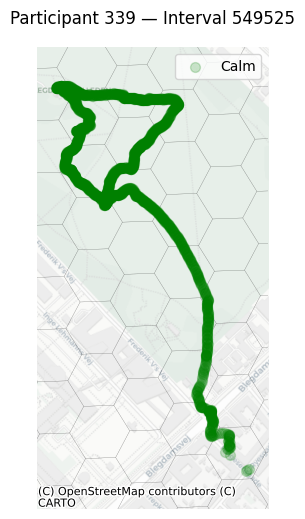

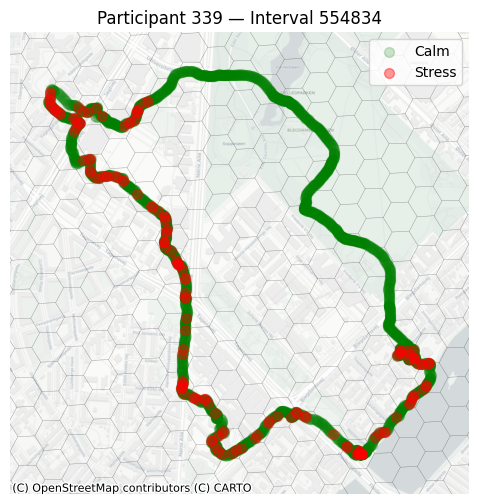

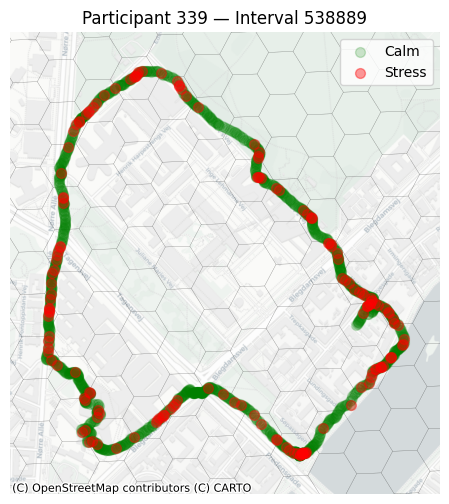

In [ ]:
# interval_ids = gps_participant_plot["Interval ID"].unique()
interval_ids = [549525, 554834, 538889]

for iid in interval_ids:
    gps_i = gps_participant_plot[gps_participant_plot["Interval ID"] == iid]

    if len(gps_i) == 0:
        continue

    # bounds
    minx, miny, maxx, maxy = gps_i.total_bounds
    pad_x = (maxx - minx) * 0.1
    pad_y = (maxy - miny) * 0.1

    # clip hex grid
    hex_clip = hex_gdf.cx[
        minx - pad_x : maxx + pad_x,
        miny - pad_y : maxy + pad_y
    ]

    fig, ax = plt.subplots(figsize=(6, 6))

    # plot hex grid
    hex_clip.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        linewidth=0.2,
        alpha=0.3,
        zorder=2
    )

    # calm points
    gps_i[gps_i["stress_binary"] == 0].plot(
        ax=ax,
        color="green",
        markersize=50,
        alpha=0.2,
        label="Calm",
        zorder=3
    )

    # stress points
    gps_i[gps_i["stress_binary"] == 1].plot(
        ax=ax,
        color="red",
        markersize=50,
        alpha=0.4,
        label="Stress",
        zorder=3
    )

    # zoom
    ax.set_xlim(minx - pad_x, maxx + pad_x)
    ax.set_ylim(miny - pad_y, maxy + pad_y)

    # add Copenhagen basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,  # clean thesis style
        zoom=16
    )

    ax.set_title(f"Participant {participant} — Interval {iid}")
    ax.legend()
    ax.set_axis_off()

    plt.show()
    outpath = f"/home/s232713/figures/stress_trajectory_example_{participant}_interval_{iid}.pdf"
    fig.savefig(
        outpath,
        format="pdf",
        bbox_inches="tight"
    )

    plt.close(fig)

In [ ]:
df = pd.read_csv("/home/s232713/data/foot_time_env.csv")
print(df.columns.values)
# focus on one participant
individ = gps_participant_plot['INDIVID'].unique()[0] 
print(f"Focusing on INDIVID {individ}")
df_p = df[df["INDIVID"] == individ].copy()
display(df_p.head())

['INDIVID' 'Interval ID' 'GRID_ID' 't_entry' 't_exit' 'type'
 'Start Time_x' 'stress' 'start_dt' 'year' 'month' 'day' 'date' 'is_day'
 'grid_ndvi_min' 'grid_ndvi_max' 'grid_ndvi_mean' 'grid_ndvi_std'
 'mean_temp' 'acc_precip' 'bright_sunshine' 'mean_wind_speed'
 'mean_relative_hum' 'mean_pressure' 'mean_cloud_cover' 'day_L_mean'
 'day_L_std' 'day_L_min' 'day_L_max' 'day_share_quiet_' 'day_share_45_50'
 'day_share_50_55' 'day_share_55_60' 'day_share_60_65' 'day_share_65_70'
 'day_share_70_75' 'day_share_75_80' 'day_is_censored' 'night_L_mean'
 'night_L_std' 'night_L_min' 'night_L_max' 'night_share_quiet_'
 'night_share_45_50' 'night_share_50_55' 'night_share_55_60'
 'night_share_60_65' 'night_share_65_70' 'night_share_70_75'
 'night_share_75_80' 'night_is_censored' 'noise_L_mean' 'noise_L_min'
 'noise_L_max' 'noise_L_std' 'noise_share_quiet_' 'noise_share_45_50'
 'noise_share_50_55' 'noise_share_55_60' 'noise_share_60_65'
 'noise_share_65_70' 'noise_share_70_75' 'noise_share_75_80' 'lat

,INDIVID,Interval ID,GRID_ID,t_entry,t_exit,type,Start Time_x,stress,start_dt,year,...,Wall,Utility Pole,Sky,Pole,Bicyclist,Bus,Lane Marking - General,Other Rider,Curb,Bicycle
21528,MMM21201,538889,281238,2024-04-27 08:16:22,2024-04-27 08:16:53,line_cross,2024-04-27 08:04:09,1,2024-04-27 08:04:09,2024,...,0.027542,0.552928,20.517128,0.458463,0.344111,0.000687,1.610913,0.0,8.223648,0.325618
21529,MMM21201,538889,281239,2024-04-27 08:15:43,2024-04-27 08:16:15,line_cross,2024-04-27 08:04:09,1,2024-04-27 08:04:09,2024,...,0.452423,0.000034,11.902050,0.523529,0.101547,0.000543,0.637029,0.0,6.643507,0.127695
21530,MMM21201,538889,281240,2024-04-27 08:15:05,2024-04-27 08:15:21,line_cross,2024-04-27 08:04:09,1,2024-04-27 08:04:09,2024,...,0.124842,0.068130,8.979988,0.389366,0.058123,0.089417,1.350746,0.0,8.998718,0.047709
21531,MMM21201,538889,281802,2024-04-27 08:19:18,2024-04-27 08:19:44,buffer_only,2024-04-27 08:04:09,1,2024-04-27 08:04:09,2024,...,0.319583,0.432841,10.740102,0.422211,0.000000,0.014305,0.004336,0.0,15.020371,0.000000
21532,MMM21201,538889,281803,2024-04-27 08:18:15,2024-04-27 08:19:25,line_cross,2024-04-27 08:04:09,1,2024-04-27 08:04:09,2024,...,1.079547,0.026728,14.499003,0.355911,0.000000,0.000000,0.060310,0.0,0.157064,0.000000


In [ ]:
env_features = [
    # greenery
    "grid_ndvi_mean",

    # noise
    "noise_L_mean",

    # built environment
    "roads_transportation",
    "poi_transportation",

    # urban structure
    "Building",
    "Vegetation",

    # weather
    'mean_temp', 
    'acc_precip', 
    'bright_sunshine',
    'mean_cloud_cover'
]



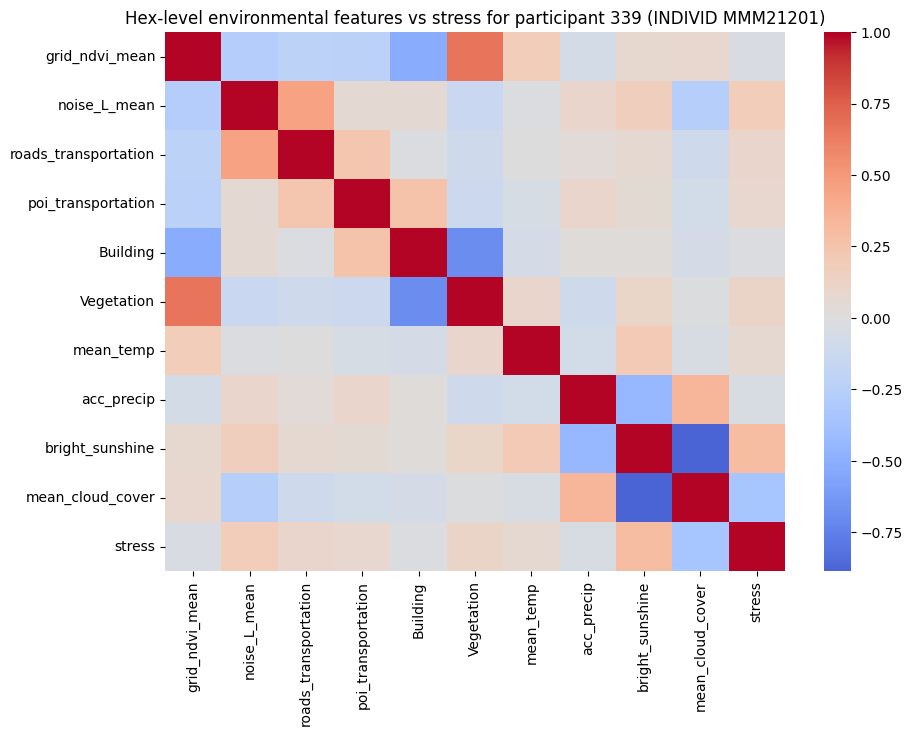

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = df_p[env_features + ["stress"]].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title(f"Hex-level environmental features vs stress for participant {participant} (INDIVID {individ})")
plt.show()


In [ ]:
df_p["noise_L_mean"].describe()


count    1480.000000
mean       59.069843
std         4.842784
min        42.500000
25%        55.081615
50%        59.934814
75%        62.822945
max        70.000000
Name: noise_L_mean, dtype: float64

In [ ]:
df_p["noise_L_mean"].nunique()


160

In [ ]:
## hex level stress rate plot
gps_all = gps_stress_df.copy()

gps_all["geometry"] = gps_all.apply(
    lambda r: Point(r["Longitude"], r["Latitude"]),
    axis=1
)

gps_all = gpd.GeoDataFrame(
    gps_all,
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

# spatial join GPS with hex grid
gps_hex = gpd.sjoin(
    gps_all,
    hex_gdf,
    how="left",
    predicate="within"
)

# aggregate per hex
hex_stress = (
    gps_hex
    .groupby("index_right")
    .agg(
        stress_rate=("stress_binary", "mean"),
        stress_count=("stress_binary", "sum"),
        n_points=("stress_binary", "count"),
        n_participants=("participant ID", "nunique")
    )
)

# merge back to hex grid
hex_plot = hex_gdf.join(hex_stress)

# mask low-sample hexes
hex_plot.loc[
    (hex_plot["n_points"] < 20) | (hex_plot["n_participants"] < 3),
    "stress_rate"
] = None



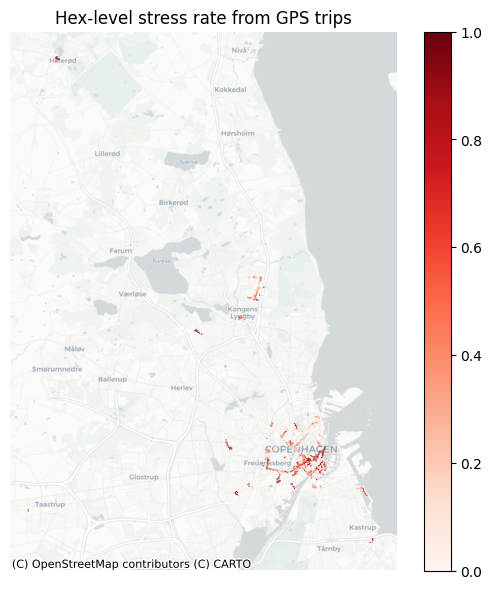

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

hex_plot.plot(
    column="stress_rate",
    cmap="Reds",
    linewidth=0,
    legend=True,
    ax=ax,
    #missing_kwds={"color": "lightgrey"}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"Hex-level stress rate from GPS trips")
ax.set_axis_off()
plt.show()

In [ ]:
# GPS stress data (all participants)
gps_df = pd.read_csv("/home/s232713/data/gps_trip_stress.csv")

# Hex grid
hex_gdf = gpd.read_file("/home/s232713/data/grid_data/cph_hexgrid.geojson").to_crs(epsg=3857)

# Environmental hex-level data
env_df = pd.read_csv("/home/s232713/data/foot_time_env.csv")

gps_df["geometry"] = gps_df.apply(
    lambda r: Point(r["Longitude"], r["Latitude"]),
    axis=1
)

gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry="geometry",
    crs="EPSG:4326"
).to_crs(epsg=3857)

gps_hex = gpd.sjoin(
    gps_gdf,
    hex_gdf,
    how="left",
    predicate="within"
)

# print(gps_hex.columns)


In [ ]:
hex_stress = (
    gps_hex
    .groupby("index_right")
    .agg(
        stress_rate=("stress_binary", "mean"),
        stress_count=("stress_binary", "sum"),
        n_points=("stress_binary", "count"),
        n_participants=("participant ID", "nunique")
    )
)

hex_plot = hex_gdf.join(hex_stress)

hex_plot.loc[
    (hex_plot["n_points"] < 20) | (hex_plot["n_participants"] < 3),
    "stress_rate"
] = None

env_hex = (
    env_df
    .groupby("GRID_ID")
    .agg(
        grid_ndvi_mean=("grid_ndvi_mean", "mean"),
        noise_L_mean=("noise_L_mean", "mean"),
        roads_transportation=("roads_transportation", "mean"),
        poi_transportation=("poi_transportation", "mean"),
        Building=("Building", "mean"),
        Vegetation=("Vegetation", "mean"),
        Temperature=("mean_temp", "mean"),
        Precipitation=("acc_precip", "mean"),
        Sunshine=("bright_sunshine", "mean"),
        CloudCover=("mean_cloud_cover", "mean")
    )
)

hex_plot = hex_plot.join(env_hex)



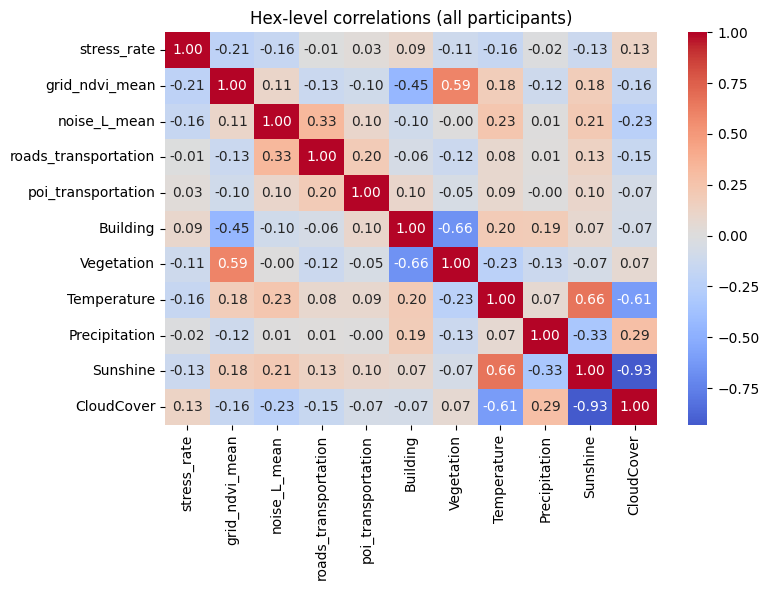

In [ ]:
hex_vars = [
    "stress_rate",
    "grid_ndvi_mean",
    "noise_L_mean",
    "roads_transportation",
    "poi_transportation",
    "Building",
    "Vegetation",
    "Temperature",
    "Precipitation",
    "Sunshine",
    "CloudCover"
]

corr_hex = (
    hex_plot[hex_vars]
    .dropna()
    .corr()
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_hex,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Hex-level correlations (all participants)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# list of INDIVID high quality data
individ_list = [
    "MMM21201",
    "MMM15201",
    "MMM15601",
    "MMM13401",
    "MMM12601"
]

# keep only mapping INDIVID -> participant ID
mapping = (
    gps_df[["INDIVID", "participant ID"]]
    .drop_duplicates()
)

# filter to your INDIVIDs
result = mapping[mapping["INDIVID"].isin(individ_list)]

print(result)


         INDIVID  participant ID
3844    MMM12601             118
78532   MMM13401             130
213803  MMM15201             109
265500  MMM15601             148
774039  MMM21201             339


In [ ]:
# pick one participant and one interval
pid = 118

gps_p = gps_gdf[gps_gdf["participant ID"] == pid]

# pick longest interval
interval_id = (
    gps_p["Interval ID"]
    .value_counts()
    .idxmax()
)

traj = gps_p[gps_p["Interval ID"] == interval_id].copy()
traj = traj.sort_values("Timestamp")

print(f"Participant {pid}, interval {interval_id}, n={len(traj)}")


Participant 118, interval 286076, n=1602


In [ ]:
traj_hex = gpd.sjoin(
    traj,
    hex_plot[[
        "geometry",
        "grid_ndvi_mean",
        "noise_L_mean",
        "roads_transportation",
        "poi_transportation"
    ]],
    how="left",
    predicate="within"
)

# smooth stress to avoid flickering (window ~10 samples)
traj_hex["stress_smooth"] = (
    traj_hex["stress_binary"]
    .rolling(window=10, center=True, min_periods=1)
    .mean()
)



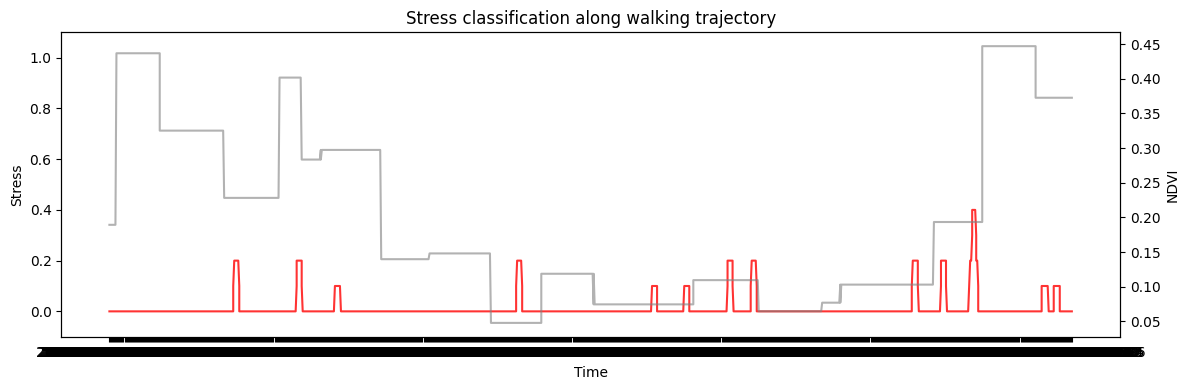

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# stress signal
ax1.plot(
    traj_hex["Timestamp"],
    traj_hex["stress_smooth"],
    color="red",
    alpha=0.8,
    label="Stress (smoothed)"
)

ax1.set_ylabel("Stress")
ax1.set_ylim(-0.1, 1.1)

# environment on second axis
ax2 = ax1.twinx()
ax2.plot(
    traj_hex["Timestamp"],
    traj_hex["grid_ndvi_mean"],
    color="grey",
    alpha=0.6,
    label="Hex-level NDVI"
)

ax2.set_ylabel("NDVI")

ax1.set_title("Stress classification along walking trajectory")
ax1.set_xlabel("Time")

fig.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# good quality participants
# good_pids = [118, 130, 109, 148, 339]
good_pids = [339]

# filters
MIN_DURATION_SEC = 5 * 60     # 5 minutes
MIN_STRESS_STD = 0.05         # variability threshold

for pid in good_pids:
    gps_p = gps_gdf[gps_gdf["participant ID"] == pid]

    # interval_ids = gps_p["Interval ID"].unique()
    interval_ids = [549525]

    for interval_id in interval_ids:
        traj = gps_p[gps_p["Interval ID"] == interval_id].copy()

        # timestamps + sort
        traj["Timestamp"] = pd.to_datetime(traj["Timestamp"])
        traj = traj.sort_values("Timestamp")

        # duration filter
        duration_sec = (
            traj["Timestamp"].iloc[-1] - traj["Timestamp"].iloc[0]
        ).total_seconds()

        if duration_sec < MIN_DURATION_SEC:
            continue

        print(f"Participant {pid}, interval {interval_id}, duration {duration_sec:.0f}s")

        # attach hex-level environment
        traj_hex = gpd.sjoin(
            traj,
            hex_plot[[
                "geometry",
                "grid_ndvi_mean",
                "noise_L_mean",
                "roads_transportation",
                "poi_transportation"
            ]],
            how="left",
            predicate="within"
        )

        # smooth stress to avoid flickering
        traj_hex["stress_smooth"] = (
            traj_hex["stress_binary"]
            .rolling(window=10, center=True, min_periods=1)
            .mean()
        )

        # stress variability filter
        if traj_hex["stress_smooth"].std() < MIN_STRESS_STD:
            continue

        # ---- PLOT ----
        fig, ax1 = plt.subplots(figsize=(12, 4))

        ax1.plot(
            traj_hex["Timestamp"],
            traj_hex["stress_smooth"],
            color="red",
            alpha=0.8,
            label="Stress (smoothed)"
        )

        ax1.set_ylabel("Stress")
        ax1.set_ylim(-0.1, 1.1)

        ax2 = ax1.twinx()
        ax2.plot(
            traj_hex["Timestamp"],
            traj_hex["grid_ndvi_mean"],
            color="grey",
            alpha=0.6,
            label="Hex-level NDVI"
        )

        ax2.set_ylabel("NDVI")

        ax1.set_title(f"Participant {pid} — Interval {interval_id}")
        ax1.set_xlabel("Time")

        fig.tight_layout()
        plt.show()


Participant 339, interval 549525, duration 1800s


| Type             | Participant | Interval   | Use in thesis             |
| ---------------- | ----------- | ---------- | ------------------------- |
| A (calm)         | 339         | 579090     | Optional / appendix       |
| A/C              | 339         | 577303     | Optional                  |
| **B (reactive)** | **339**     | **549525** | **Main figure candidate** |
| **B (reactive)** | **148**     | **383465** | **Main / secondary**      |
| C (fragmented)   | 339         | 549795     | Do not show               |
| C (fragmented)   | 148         | 383467     | Do not show               |


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# good quality participants
#good_pids = [118, 130, 109, 148, 339]
good_pids = [339]

# filters
MIN_DURATION_SEC = 5 * 60     # 5 minutes
MIN_STRESS_STD = 0.05         # variability threshold

for pid in good_pids:
    gps_p = gps_gdf[gps_gdf["participant ID"] == pid]

    #interval_ids = gps_p["Interval ID"].unique()
    interval_ids = [549525]

    for interval_id in interval_ids:
        traj = gps_p[gps_p["Interval ID"] == interval_id].copy()

        # timestamps + sort
        traj["Timestamp"] = pd.to_datetime(traj["Timestamp"])
        traj = traj.sort_values("Timestamp")

        # duration filter
        duration_sec = (
            traj["Timestamp"].iloc[-1] - traj["Timestamp"].iloc[0]
        ).total_seconds()

        if duration_sec < MIN_DURATION_SEC:
            continue

        print(f"Participant {pid}, interval {interval_id}, duration {duration_sec:.0f}s")

        # attach hex-level environment
        traj_hex = gpd.sjoin(
            traj,
            hex_plot[[
                "geometry",
                "grid_ndvi_mean",
                "noise_L_mean",
                "roads_transportation",
                "poi_transportation"
            ]],
            how="left",
            predicate="within"
        )

        # smooth stress to avoid flickering
        traj_hex["stress_smooth"] = (
            traj_hex["stress_binary"]
            .rolling(window=10, center=True, min_periods=1)
            .mean()
        )

        # stress variability filter
        if traj_hex["stress_smooth"].std() < MIN_STRESS_STD:
            continue

        # ---- PLOT ----
        fig, ax1 = plt.subplots(figsize=(12, 4))

        ax1.plot(
            traj_hex["Timestamp"],
            traj_hex["stress_smooth"],
            color="red",
            alpha=0.8,
            label="Stress (smoothed)"
        )

        ax1.set_ylabel("Stress")
        ax1.set_ylim(-0.1, 1.1)

        ax2 = ax1.twinx()
        ax2.plot(
            traj_hex["Timestamp"],
            traj_hex["noise_L_mean"],
            color="grey",
            alpha=0.6,
            label="Hex-level Noise"
        )

        ax2.set_ylabel("Noise")

        ax1.set_title(f"Participant {pid} — Interval {interval_id}")
        ax1.set_xlabel("Time")

        fig.tight_layout()
        plt.show()

Participant 339, interval 549525, duration 1800s
